In [5]:
import os
import glob
import numpy as np
import pandas as pd 
from tqdm import tqdm
import PIL
from PIL import Image
import cv2
import ast

from typing import List, Tuple, Dict

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.densenet import preprocess_input
from tensorflow.keras.layers import BatchNormalization, Dropout
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import regularizers
from tensorflow.keras import models, layers, regularizers
from tensorflow.keras.layers import concatenate, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras import layers, models, optimizers, regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical, image_dataset_from_directory
from tensorflow.keras.layers import Dense, Input, Dropout, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.layers import LeakyReLU

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from skimage.feature import greycomatrix, greycoprops
from skimage.filters import gabor
from sklearn.metrics import confusion_matrix, classification_report, pairwise
from sklearn.model_selection import train_test_split

from skimage import io, color
import gensim as gs
import gensim.downloader as gdownloader

from keras.applications import ResNet50

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt

# tf.get_available_gpus()

In [6]:
batch_size = 16
img_height = 224
img_width = 224

In [7]:
# function
# Function to extract visual features using ResNet50
def extract_visual_features(image_path):
    img = Image.open(image_path)
    img = img.resize((224, 224))  # Resize image for ResNet50 input
    img_array = np.array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = tf.keras.applications.resnet50.preprocess_input(img_array)

    model = ResNet50(weights='imagenet', include_top=False, pooling='avg')
    visual_features = model.predict(img_array, verbose = 0)

    return visual_features

# Function to compute GLCM texture features
def compute_GLCM_texture_features(image_path):
    # Define your GLCM properties (distances and angles)
    distances = [1, 3, 5, 3, 1, 3, 5]
    angles = [0, 0, 0, np.pi/4, np.pi/2, np.pi/2, np.pi/2]
    
    glcm_features = []
    for distance, angle in zip(distances, angles):
        img_gray = Image.open(image_path).convert('L')  # Convert image to grayscale
        img_gray_array = np.array(img_gray)

        # Compute GLCM properties
        glcm = greycomatrix(img_gray_array, distances=[distance], angles=[angle], levels=256, symmetric=True, normed=True)
        contrast = greycoprops(glcm, 'contrast')[0, 0]
        dissimilarity = greycoprops(glcm, 'dissimilarity')[0, 0]
        homogeneity = greycoprops(glcm, 'homogeneity')[0, 0]
        energy = greycoprops(glcm, 'energy')[0, 0]
        correlation = greycoprops(glcm, 'correlation')[0, 0]       
        
        glcm_features.extend([contrast, dissimilarity, homogeneity, energy, correlation])
        
    return np.array(glcm_features) # np.array([contrast, dissimilarity, homogeneity, energy, correlation])

# Function to compute Gabor texture features
def compute_gabor_features(image_path):
    # Load and convert the image to grayscale
    img_gray = Image.open(image_path).convert('L')
    img_gray_array = np.array(img_gray)

    # Define Gabor filter parameters
    frequencies = [0.1, 0.3, 0.5]  # Different frequencies
    thetas = [0, np.pi/4, np.pi/2, 3*np.pi/4]  # Different orientations

    gabor_features = []
    
    for frequency in frequencies:
        for theta in thetas:
            # Apply Gabor filter
            real, imag = gabor(img_gray_array, frequency=frequency, theta=theta)
            
            # Compute statistical features from the filtered image
            mean_real = np.mean(real)
            std_real = np.std(real)
            mean_imag = np.mean(imag)
            std_imag = np.std(imag)
            
            gabor_features.extend([mean_real, std_real, mean_imag, std_imag])
    
    return np.array(gabor_features)  # Return feature vector

# Load image data and compute features
def load_data_and_compute_features(data_dir):
    visual_features = []
    GLCM_texture_features = []
    gabor_texture_features = []
    labels = []

    classes = os.listdir(data_dir)
    class_to_index = {cls: idx for idx, cls in enumerate(classes)}
    # print(f"classes : {classes} \nclass_to_index : {class_to_index}")

    for cls in tqdm(classes, desc="Processing images"):
        cls_dir = os.path.join(data_dir, cls)

        for img_name in os.listdir(cls_dir):
            img_path = os.path.join(cls_dir, img_name)

            # Extract visual features using ResNet50
            visual_feat = extract_visual_features(img_path)
            visual_features.append(visual_feat)
            # print(f"visual_features : {visual_features}")

            # Compute texture features using GLCM
            GLCM_texture_feat = compute_GLCM_texture_features(img_path)
            GLCM_texture_features.append(GLCM_texture_feat)
            # print(f"texture_features : {texture_features}")
            
            # Compute texture features using gabor
            gabor_texture_feat = compute_gabor_features(img_path)
            gabor_texture_features.append(gabor_texture_feat)
            # print(f"texture_features : {texture_features}")
            
            # Assign label index
            labels.append(class_to_index[cls])
            # print(f"img_path : {img_path} || labels : {class_to_index[cls]} \n")
            # print(f"texture_features : {texture_feat} \n")
        
        print(f'Finish with {cls}.')

    visual_features = np.array(visual_features)
    GLCM_texture_features = np.array(GLCM_texture_features)
    gabor_texture_features = np.array(gabor_texture_features)
    labels = np.array(labels)

    return visual_features, GLCM_texture_features, gabor_texture_features, labels

In [57]:
TRAIN_DATA_PATH = os.path.join('..', 'Dataset', 'artefact1', 'train')
VAL_DATA_PATH = os.path.join('..', 'Dataset', 'artefact1', 'test')
UNSEEN_DATA_PATH = os.path.join('..', 'Dataset', 'artefact1', 'unseen')

# train_data = image_dataset_from_directory(TRAIN_DATA_PATH,
#                                           labels="inferred",
#                                           label_mode="int",
# #                                           validation_split=0.15,
# #                                           subset="training",
#                                           seed=123,
#                                           image_size=(img_height, img_width),
#                                           batch_size=batch_size)

# val_data = image_dataset_from_directory(VAL_DATA_PATH,
#                                         labels="inferred",
#                                         label_mode="int",
# #                                         validation_split=0.15,
# #                                         subset="validation",
#                                         seed=123,
#                                         image_size=(img_height, img_width),
#                                         batch_size=batch_size)

# lenth_train_data = len(train_data.file_paths)
# lenth_val_data = len(val_data.file_paths)
# print(lenth_train_data,  lenth_val_data)

# load_data_and_compute_features
data_directory = VAL_DATA_PATH # TRAIN_DATA_PATH
visual_features, GLCM_texture_features, gabor_texture_features, labels = load_data_and_compute_features(data_directory)
print('Done')
print(visual_features.shape, GLCM_texture_features.shape, gabor_texture_features.shape, labels.shape)

In [10]:
data_vt = pd.DataFrame(np.concatenate([visual_features.reshape(visual_features.shape[0], -1), 
                                       GLCM_texture_features, 
                                       gabor_texture_features], 
                                      axis=1))
data_vt['labels'] = labels

data_vt.to_csv('20250301_CNN_GLCM_GABOR_data_visual_features_texture_features_labels.csv', index=False)

In [11]:
data_vt

0         1         2         3         4         5         6  \
0    0.274488  0.721796  0.303247  0.573370  1.254555  1.441841  0.098317   
1    0.005659  0.879446  0.281234  0.049792  0.753348  0.276890  0.000000   
2    0.633644  1.020926  0.226682  0.056025  0.537491  2.185169  0.006372   
3    1.266745  0.932727  0.100665  0.850949  0.888651  0.232463  0.000000   
4    0.167365  0.595410  0.061694  0.220444  0.185746  0.568198  0.019383   
..        ...       ...       ...       ...       ...       ...       ...   
139  0.373288  2.030698  0.221589  0.833916  0.165265  0.000000  0.025920   
140  0.000000  3.631506  0.084142  0.012614  0.095835  0.051548  0.655720   
141  0.061549  0.044882  0.238300  0.150894  0.038403  1.681820  2.750511   
142  0.317261  0.282286  2.252604  0.000000  0.002698  0.000331  0.000000   
143  0.000000  2.186732  0.012313  0.920657  0.561201  0.519121  0.000000   

            7         8         9  ...       2122       2123       2124  2125  \
0    1.390693  0.032306  0.542915  ...   6.516218   0.814799  12.905736   0.0   
1    0.274443  0.179016  0.861253  ...  40.211431  24.117819  73.893565   0.0   
2    0.006435  0.836277  0.244573  ...  23.155223   2.228549  23.073786   0.0   
3    0.673906  0.136839  0.223846  ...  18.895001   2.391364  23.777926   0.0   
4    1.098392  0.141252  0.394051  ...  39.174530   7.107568  41.484189   0.0   
..        ...       ...       ...  ...        ...        ...        ...   ...   
139  0.392434  0.125743  0.451695  ...  49.457588  16.320241  61.447207   0.0   
140  0.036969  1.278853  0.003487  ...  40.801833  24.059699  73.740876   0.0   
141  0.597348  0.161187  0.000000  ...  40.243273  17.293343  63.487671   0.0   
142  0.696634  2.280653  0.184445  ...  25.938038  10.950720  50.973402   0.0   
143  0.791510  0.465780  0.000000  ...  84.013583  36.228826  87.575586   0.0   

     2126       2127       2128       2129       2130  labels  
0     0.0   0.137700   5.827199   0.266392   8.212627       0  
1     0.0   4.079196  31.784676   5.967675  38.462424       0  
2     0.0   1.040614  16.092622   1.524666  19.595148       0  
3     0.0   0.607552  12.294591   0.946401  15.465357       0  
4     0.0   2.187948  23.369873   2.817058  26.580819       0  
..    ...        ...        ...        ...        ...     ...  
139   0.0   7.280709  42.175656   9.568486  48.269961      17  
140   0.0   3.957720  31.260958   7.028397  41.650506      17  
141   0.0   2.837340  26.537233   4.800309  34.574980      17  
142   0.0   0.980540  15.561427   2.122641  23.115453      17  
143   0.0  25.242644  75.557192  30.898637  82.745313      17  

[144 rows x 2132 columns]

# Model train and test

In [12]:
# lib's
from pickle import dump , load

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split

import keras
from keras.models import Model, load_model
from keras.layers import Input, Dense, Concatenate, Flatten
from keras.optimizers import Adam

import matplotlib.pyplot as plt

# !pip install h5py

import h5py


In [14]:
# Variable's
min_max_scaler_file = 'min_max_scaler_pkl_model.pkl'

In [16]:
# Function
# Build and train a classification model
# def build_and_train_model(visual_features, texture_features, labels):
def build_and_train_model(df):
    # Concatenate visual and texture features
#     combined_features = np.concatenate([visual_features, 
#                                         texture_features], 
#                                        axis=1)
#     combined_features = np.concatenate([visual_features.reshape(visual_features.shape[0], -1), 
#                                         texture_features], 
#                                        axis=1)
    combined_features, labels = df.iloc[:,:-1], df.iloc[:,-1]
    
    
    # Normalize the features
    min_max_scaler = StandardScaler()
    train_normalized_texture_features = min_max_scaler.fit_transform(combined_features)
    train_normalized_texture_features_df = pd.DataFrame(train_normalized_texture_features)
    
    # save 
    dump(min_max_scaler, open(min_max_scaler_file, 'wb'))

    # Split data into train and test sets
#     X_train, X_test, y_train, y_test = train_test_split(combined_features, 
#                                                         labels, 
#                                                         test_size=0.3, 
#                                                         random_state=42, 
#                                                         stratify=labels)
    X_train, X_test, y_train, y_test = train_test_split(train_normalized_texture_features_df, 
                                                        labels, 
                                                        test_size=0.3, 
                                                        random_state=42, 
                                                        stratify=labels)

    # Define classification model
    input_layer = Input(shape=(combined_features.shape[1],))
    hidden_layer = Dense(128, activation='relu')(input_layer)
    output_layer = Dense(len(np.unique(labels)), activation='softmax')(hidden_layer)

    model = Model(inputs=input_layer, outputs=output_layer)
    model.summary()
    model.compile(optimizer=Adam(lr=0.001), 
                  loss='sparse_categorical_crossentropy', 
                  metrics=['accuracy'])

    # Train the model
    history = model.fit(X_train, y_train, 
                        epochs=100, 
                        batch_size=64, 
                        validation_data=(X_test, y_test))
    
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc)+1)

    plt.plot(epochs, acc, label='training accuracy')
    plt.plot(epochs, val_acc, label='validation accuracy')
    plt.legend()
    plt.xlabel('epochs')
    plt.ylabel('accuracy')
    plt.title('Training validation Accuracy')
    plt.show()

    plt.plot(epochs, loss, label='training loss')
    plt.plot(epochs, val_loss, label='validation loss')
    plt.legend()
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.title('Training validation Loss')
    plt.show()

    return model # history # model

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_857 (InputLayer)      [(None, 2131)]            0         
                                                                 
 dense (Dense)               (None, 128)               272896    
                                                                 
 dense_1 (Dense)             (None, 18)                2322      
                                                                 
Total params: 275218 (1.05 MB)
Trainable params: 275218 (1.05 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Epoch 1/100



2/2 [==============================] - 2s 303ms/step - loss: 3.5880 - accuracy: 0.0800 - val_loss: 1.9478 - val_accuracy: 0.4318
Epoch 2/100
2/2 [==============================] - 0s 65ms/step - loss: 0.8629 - accuracy: 0.8600 - val_loss: 1.0229 - val_accuracy: 0.8182
Epoch 3/100
2/2 [==============================] - 0s 60ms/step - loss: 0.1534 - accuracy: 0.9900 - val_loss: 0.6379 - val_accuracy: 0.8636
Epoch 4/100
2/2 [==============================] - 0s 56ms/step - loss: 0.0422 - accuracy: 1.0000 - val_loss: 0.4742 - val_accuracy: 0.9091
Epoch 5/100
2/2 [==============================] - 0s 52ms/step - loss: 0.0115 - accuracy: 1.0000 - val_loss: 0.3956 - val_accuracy: 0.8864
Epoch 6/100
2/2 [==============================] - 0s 53ms/step - loss: 0.0048 - accuracy: 1.0000 - val_loss: 0.3565 - val_accuracy: 0.9091
Epoch 7/100
2/2 [==============================] - 0s 58ms/step - loss: 0.0024 - accuracy: 1.0000 - val_loss: 0.3349 - val_accuracy: 0.9091
Epoch 8/100
2/2 [==============

Epoch 58/100
2/2 [==============================] - 0s 52ms/step - loss: 9.8343e-05 - accuracy: 1.0000 - val_loss: 0.2954 - val_accuracy: 0.9318
Epoch 59/100
2/2 [==============================] - 0s 45ms/step - loss: 9.7342e-05 - accuracy: 1.0000 - val_loss: 0.2952 - val_accuracy: 0.9318
Epoch 60/100
2/2 [==============================] - 0s 56ms/step - loss: 9.6522e-05 - accuracy: 1.0000 - val_loss: 0.2949 - val_accuracy: 0.9318
Epoch 61/100
2/2 [==============================] - 0s 46ms/step - loss: 9.5674e-05 - accuracy: 1.0000 - val_loss: 0.2946 - val_accuracy: 0.9318
Epoch 62/100
2/2 [==============================] - 0s 55ms/step - loss: 9.4797e-05 - accuracy: 1.0000 - val_loss: 0.2944 - val_accuracy: 0.9318
Epoch 63/100
2/2 [==============================] - 0s 54ms/step - loss: 9.3952e-05 - accuracy: 1.0000 - val_loss: 0.2941 - val_accuracy: 0.9318
Epoch 64/100
2/2 [==============================] - 0s 51ms/step - loss: 9.3171e-05 - accuracy: 1.0000 - val_loss: 0.2938 - val_ac

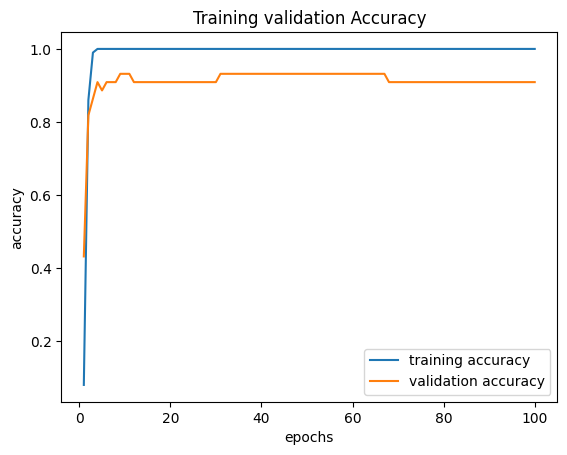

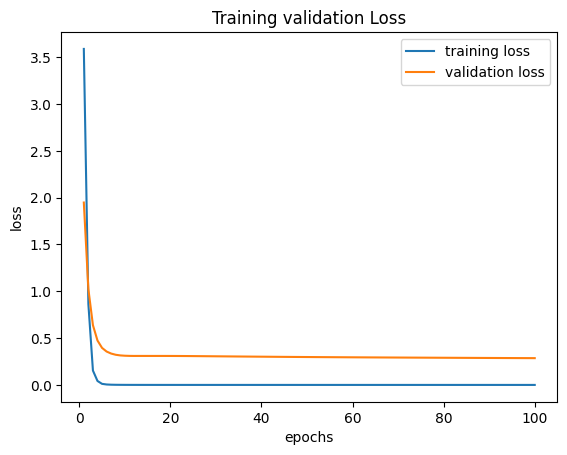

In [17]:
# load csv
data_vtl = pd.read_csv('20250301_CNN_GLCM_GABOR_data_visual_features_texture_features_labels.csv')

# Build and train the classification model
classification_model = build_and_train_model(data_vtl)
classification_model

In [18]:
# save model and architecture to single file
classification_model.save("CNN_GLCM_GABOR_model_h5.h5")
print("Saved model to disk")

Saved model to disk


# Classification Report

In [19]:
# Load models
classification_model = load_model('CNN_GLCM_GABOR_model_h5.h5')
min_max_scaler_model = load(open(min_max_scaler_file, 'rb'))
class_labels = ['bear', 'blue_whale', 'bobcat', 'cow', 'dolphin', 'gorilla', 
                'killer_whale', 'lion', 'monkey', 'mouse', 'ox', 'rabbit', 
                'rhinoceros', 'siamese_cat', 'skunk', 'squirrel', 'tiger', 'walrus']

In [30]:
# '''
# Note : Added way to read the folde images one by one.
# '''

for label in class_labels:

    folder_name = label
    folder_path = os.path.join(VAL_DATA_PATH, folder_name, '*')

    image_path, image_label, pred_image_label, act_label, pred_label = [], [], [], [], []

    # for img_path in glob.glob(r"test/*/*"):
    for img_path in glob.glob(folder_path):
    #     print(f"img_path : {img_path}")
        image_path.append(img_path)
        image_label.append(img_path.split('\\')[-2])
        act_label.append(class_labels.index(img_path.split('\\')[-2]))

        # Extract visual features using ResNet50
        visual_features = extract_visual_features(img_path)
    #     print(f"visual_features : {visual_features.shape} || {type(visual_features)}")

        # Compute texture features using GLCM
        GLCM_texture_feat = compute_GLCM_texture_features(img_path)
    #     GLCM_texture_features.append(GLCM_texture_feat)
    #     print(f"texture_features : {texture_features} || ")

        # Compute texture features using gabor
        gabor_texture_feat = compute_gabor_features(img_path)
    #     gabor_texture_features.append(gabor_texture_feat)
    #     print(f"texture_features : {texture_features}")

        # Concatenate visual and texture features
        l1 = visual_features[0].tolist()
        l2 = GLCM_texture_feat.tolist()
        l3 = gabor_texture_feat.tolist()
        l1.extend(l2)
        l1.extend(l3)
        combined_features = np.array(l1)
    #     print(f"combined_features : {combined_features}")

        # Normalize the features
        train_normalized_texture_features = min_max_scaler_model.transform([combined_features])
        train_normalized_texture_features_df = pd.DataFrame(train_normalized_texture_features)
    #     print(f"train_normalized_texture_features_df : {train_normalized_texture_features_df}")

    #     model.predict
        predicted_value = classification_model.predict(train_normalized_texture_features_df, verbose = 0)
    #     print(f"predicted_value : {np.argmax(predicted_value)} || {class_labels[np.argmax(predicted_value)]}")
        pred_image_label.append(class_labels[np.argmax(predicted_value)])
        pred_label.append(np.argmax(predicted_value))

    #     break

    # check result
    out_df = pd.DataFrame({
        'image_path' : image_path, 
        'image_label' : image_label, 
        'pred_image_label' : pred_image_label, 
        'act_label' : act_label, 
        'pred_label' : pred_label
    })
    display(out_df.head())

    # save csv
    metadata_folder_name = 'CNN_GLCM_GABOR_metadata'
    os.makedirs(metadata_folder_name, exist_ok=True) 
    metadata_file_name = os.path.join(metadata_folder_name, folder_name + '_CNN_GLCM_GABOR_result.csv')
    out_df.to_csv(metadata_file_name, index = False)
    
    print(f"Save file : {metadata_file_name}")


C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

image_path image_label  \
0  ..\Dataset\artefact1\test\bear\bear_10001 (89)...        bear   
1  ..\Dataset\artefact1\test\bear\bear_10001 (90)...        bear   
2  ..\Dataset\artefact1\test\bear\bear_10001 (91)...        bear   
3  ..\Dataset\artefact1\test\bear\bear_10001 (92)...        bear   
4  ..\Dataset\artefact1\test\bear\bear_10001 (93)...        bear   

  pred_image_label  act_label  pred_label  
0             bear          0           0  
1             bear          0           0  
2             bear          0           0  
3             bear          0           0  
4             bear          0           0

Save file : CNN_GLCM_GABOR_metadata\bear_CNN_GLCM_GABOR_result.csv


C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

image_path image_label  \
0  ..\Dataset\artefact1\test\blue_whale\blue+whal...  blue_whale   
1  ..\Dataset\artefact1\test\blue_whale\blue+whal...  blue_whale   
2  ..\Dataset\artefact1\test\blue_whale\blue+whal...  blue_whale   
3  ..\Dataset\artefact1\test\blue_whale\blue+whal...  blue_whale   
4  ..\Dataset\artefact1\test\blue_whale\blue+whal...  blue_whale   

  pred_image_label  act_label  pred_label  
0       blue_whale          1           1  
1       blue_whale          1           1  
2       blue_whale          1           1  
3       blue_whale          1           1  
4       blue_whale          1           1

Save file : CNN_GLCM_GABOR_metadata\blue_whale_CNN_GLCM_GABOR_result.csv


C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

image_path image_label  \
0  ..\Dataset\artefact1\test\bobcat\bobcat_10067.jpg      bobcat   
1  ..\Dataset\artefact1\test\bobcat\bobcat_10068.jpg      bobcat   
2  ..\Dataset\artefact1\test\bobcat\bobcat_10069.jpg      bobcat   
3  ..\Dataset\artefact1\test\bobcat\bobcat_10070.jpg      bobcat   
4  ..\Dataset\artefact1\test\bobcat\bobcat_10071.jpg      bobcat   

  pred_image_label  act_label  pred_label  
0           bobcat          2           2  
1           bobcat          2           2  
2           bobcat          2           2  
3           bobcat          2           2  
4           bobcat          2           2

Save file : CNN_GLCM_GABOR_metadata\bobcat_CNN_GLCM_GABOR_result.csv


C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

image_path image_label pred_image_label  \
0  ..\Dataset\artefact1\test\cow\cow_10090.jpg         cow              cow   
1  ..\Dataset\artefact1\test\cow\cow_10091.jpg         cow              cow   
2  ..\Dataset\artefact1\test\cow\cow_10092.jpg         cow              cow   
3  ..\Dataset\artefact1\test\cow\cow_10093.jpg         cow              cow   
4  ..\Dataset\artefact1\test\cow\cow_10094.jpg         cow              cow   

   act_label  pred_label  
0          3           3  
1          3           3  
2          3           3  
3          3           3  
4          3           3

Save file : CNN_GLCM_GABOR_metadata\cow_CNN_GLCM_GABOR_result.csv


C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

image_path image_label  \
0  ..\Dataset\artefact1\test\dolphin\dolphin_1007...     dolphin   
1  ..\Dataset\artefact1\test\dolphin\dolphin_1007...     dolphin   
2  ..\Dataset\artefact1\test\dolphin\dolphin_1008...     dolphin   
3  ..\Dataset\artefact1\test\dolphin\dolphin_1008...     dolphin   
4  ..\Dataset\artefact1\test\dolphin\dolphin_1008...     dolphin   

  pred_image_label  act_label  pred_label  
0     killer_whale          4           6  
1          dolphin          4           4  
2      siamese_cat          4          13  
3          dolphin          4           4  
4          dolphin          4           4

Save file : CNN_GLCM_GABOR_metadata\dolphin_CNN_GLCM_GABOR_result.csv


C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

image_path image_label  \
0  ..\Dataset\artefact1\test\gorilla\gorilla_1012...     gorilla   
1  ..\Dataset\artefact1\test\gorilla\gorilla_1012...     gorilla   
2  ..\Dataset\artefact1\test\gorilla\gorilla_1012...     gorilla   
3  ..\Dataset\artefact1\test\gorilla\gorilla_1012...     gorilla   
4  ..\Dataset\artefact1\test\gorilla\gorilla_1012...     gorilla   

  pred_image_label  act_label  pred_label  
0          gorilla          5           5  
1          gorilla          5           5  
2          gorilla          5           5  
3          gorilla          5           5  
4          gorilla          5           5

Save file : CNN_GLCM_GABOR_metadata\gorilla_CNN_GLCM_GABOR_result.csv


C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

image_path   image_label  \
0  ..\Dataset\artefact1\test\killer_whale\killer+...  killer_whale   
1  ..\Dataset\artefact1\test\killer_whale\killer+...  killer_whale   
2  ..\Dataset\artefact1\test\killer_whale\killer+...  killer_whale   
3  ..\Dataset\artefact1\test\killer_whale\killer+...  killer_whale   
4  ..\Dataset\artefact1\test\killer_whale\killer+...  killer_whale   

  pred_image_label  act_label  pred_label  
0     killer_whale          6           6  
1     killer_whale          6           6  
2     killer_whale          6           6  
3     killer_whale          6           6  
4     killer_whale          6           6

Save file : CNN_GLCM_GABOR_metadata\killer_whale_CNN_GLCM_GABOR_result.csv


C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

image_path image_label pred_image_label  \
0  ..\Dataset\artefact1\test\lion\lion_10067.jpg        lion             lion   
1  ..\Dataset\artefact1\test\lion\lion_10068.jpg        lion             lion   
2  ..\Dataset\artefact1\test\lion\lion_10069.jpg        lion             lion   
3  ..\Dataset\artefact1\test\lion\lion_10070.jpg        lion             lion   
4  ..\Dataset\artefact1\test\lion\lion_10071.jpg        lion             lion   

   act_label  pred_label  
0          7           7  
1          7           7  
2          7           7  
3          7           7  
4          7           7

Save file : CNN_GLCM_GABOR_metadata\lion_CNN_GLCM_GABOR_result.csv


C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

image_path image_label  \
0  ..\Dataset\artefact1\test\monkey\monkey_10003 ...      monkey   
1  ..\Dataset\artefact1\test\monkey\monkey_10003 ...      monkey   
2  ..\Dataset\artefact1\test\monkey\monkey_10003 ...      monkey   
3  ..\Dataset\artefact1\test\monkey\monkey_10003 ...      monkey   
4  ..\Dataset\artefact1\test\monkey\monkey_10003 ...      monkey   

  pred_image_label  act_label  pred_label  
0           monkey          8           8  
1           monkey          8           8  
2           monkey          8           8  
3           monkey          8           8  
4           monkey          8           8

Save file : CNN_GLCM_GABOR_metadata\monkey_CNN_GLCM_GABOR_result.csv


C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

image_path image_label  \
0  ..\Dataset\artefact1\test\mouse\mouse_10097.jpg       mouse   
1  ..\Dataset\artefact1\test\mouse\mouse_10098.jpg       mouse   
2  ..\Dataset\artefact1\test\mouse\mouse_10099.jpg       mouse   
3  ..\Dataset\artefact1\test\mouse\mouse_10100.jpg       mouse   
4  ..\Dataset\artefact1\test\mouse\mouse_10101.jpg       mouse   

  pred_image_label  act_label  pred_label  
0            mouse          9           9  
1            mouse          9           9  
2            mouse          9           9  
3            mouse          9           9  
4            mouse          9           9

Save file : CNN_GLCM_GABOR_metadata\mouse_CNN_GLCM_GABOR_result.csv


C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

image_path image_label pred_image_label  \
0  ..\Dataset\artefact1\test\ox\ox_10119.jpg          ox               ox   
1  ..\Dataset\artefact1\test\ox\ox_10120.jpg          ox               ox   
2  ..\Dataset\artefact1\test\ox\ox_10121.jpg          ox               ox   
3  ..\Dataset\artefact1\test\ox\ox_10122.jpg          ox               ox   
4  ..\Dataset\artefact1\test\ox\ox_10123.jpg          ox               ox   

   act_label  pred_label  
0         10          10  
1         10          10  
2         10          10  
3         10          10  
4         10          10

Save file : CNN_GLCM_GABOR_metadata\ox_CNN_GLCM_GABOR_result.csv


C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

image_path image_label  \
0  ..\Dataset\artefact1\test\rabbit\rabbit_10045.jpg      rabbit   
1  ..\Dataset\artefact1\test\rabbit\rabbit_10046.jpg      rabbit   
2  ..\Dataset\artefact1\test\rabbit\rabbit_10047.jpg      rabbit   
3  ..\Dataset\artefact1\test\rabbit\rabbit_10048.jpg      rabbit   
4  ..\Dataset\artefact1\test\rabbit\rabbit_10049.jpg      rabbit   

  pred_image_label  act_label  pred_label  
0           rabbit         11          11  
1           rabbit         11          11  
2           rabbit         11          11  
3           rabbit         11          11  
4           rabbit         11          11

Save file : CNN_GLCM_GABOR_metadata\rabbit_CNN_GLCM_GABOR_result.csv


C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

image_path image_label  \
0  ..\Dataset\artefact1\test\rhinoceros\rhinocero...  rhinoceros   
1  ..\Dataset\artefact1\test\rhinoceros\rhinocero...  rhinoceros   
2  ..\Dataset\artefact1\test\rhinoceros\rhinocero...  rhinoceros   
3  ..\Dataset\artefact1\test\rhinoceros\rhinocero...  rhinoceros   
4  ..\Dataset\artefact1\test\rhinoceros\rhinocero...  rhinoceros   

  pred_image_label  act_label  pred_label  
0       rhinoceros         12          12  
1       rhinoceros         12          12  
2       rhinoceros         12          12  
3       rhinoceros         12          12  
4       rhinoceros         12          12

Save file : CNN_GLCM_GABOR_metadata\rhinoceros_CNN_GLCM_GABOR_result.csv


C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

image_path  image_label  \
0  ..\Dataset\artefact1\test\siamese_cat\siamese+...  siamese_cat   
1  ..\Dataset\artefact1\test\siamese_cat\siamese+...  siamese_cat   
2  ..\Dataset\artefact1\test\siamese_cat\siamese+...  siamese_cat   
3  ..\Dataset\artefact1\test\siamese_cat\siamese+...  siamese_cat   
4  ..\Dataset\artefact1\test\siamese_cat\siamese+...  siamese_cat   

  pred_image_label  act_label  pred_label  
0      siamese_cat         13          13  
1      siamese_cat         13          13  
2      siamese_cat         13          13  
3      siamese_cat         13          13  
4      siamese_cat         13          13

Save file : CNN_GLCM_GABOR_metadata\siamese_cat_CNN_GLCM_GABOR_result.csv


C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

image_path image_label  \
0  ..\Dataset\artefact1\test\skunk\skunk_10068.jpg       skunk   
1  ..\Dataset\artefact1\test\skunk\skunk_10069.jpg       skunk   
2  ..\Dataset\artefact1\test\skunk\skunk_10070.jpg       skunk   
3  ..\Dataset\artefact1\test\skunk\skunk_10071.jpg       skunk   
4  ..\Dataset\artefact1\test\skunk\skunk_10072.jpg       skunk   

  pred_image_label  act_label  pred_label  
0            skunk         14          14  
1            skunk         14          14  
2            skunk         14          14  
3            skunk         14          14  
4            skunk         14          14

Save file : CNN_GLCM_GABOR_metadata\skunk_CNN_GLCM_GABOR_result.csv


C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

image_path image_label  \
0  ..\Dataset\artefact1\test\squirrel\squirrel_10...    squirrel   
1  ..\Dataset\artefact1\test\squirrel\squirrel_10...    squirrel   
2  ..\Dataset\artefact1\test\squirrel\squirrel_10...    squirrel   
3  ..\Dataset\artefact1\test\squirrel\squirrel_10...    squirrel   
4  ..\Dataset\artefact1\test\squirrel\squirrel_10...    squirrel   

  pred_image_label  act_label  pred_label  
0         squirrel         15          15  
1         squirrel         15          15  
2         squirrel         15          15  
3         squirrel         15          15  
4         squirrel         15          15

Save file : CNN_GLCM_GABOR_metadata\squirrel_CNN_GLCM_GABOR_result.csv


C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

image_path image_label  \
0  ..\Dataset\artefact1\test\tiger\tiger_10117.jpg       tiger   
1  ..\Dataset\artefact1\test\tiger\tiger_10118.jpg       tiger   
2  ..\Dataset\artefact1\test\tiger\tiger_10119.jpg       tiger   
3  ..\Dataset\artefact1\test\tiger\tiger_10120.jpg       tiger   
4  ..\Dataset\artefact1\test\tiger\tiger_10121.jpg       tiger   

  pred_image_label  act_label  pred_label  
0            tiger         16          16  
1            tiger         16          16  
2            tiger         16          16  
3            tiger         16          16  
4            tiger         16          16

Save file : CNN_GLCM_GABOR_metadata\tiger_CNN_GLCM_GABOR_result.csv


C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

image_path image_label  \
0  ..\Dataset\artefact1\test\walrus\walrus_10182.jpg      walrus   
1  ..\Dataset\artefact1\test\walrus\walrus_10183.jpg      walrus   
2  ..\Dataset\artefact1\test\walrus\walrus_10184.jpg      walrus   
3  ..\Dataset\artefact1\test\walrus\walrus_10185.jpg      walrus   
4  ..\Dataset\artefact1\test\walrus\walrus_10186.jpg      walrus   

  pred_image_label  act_label  pred_label  
0           walrus         17          17  
1           walrus         17          17  
2           walrus         17          17  
3           walrus         17          17  
4           walrus         17          17

Save file : CNN_GLCM_GABOR_metadata\walrus_CNN_GLCM_GABOR_result.csv


# Note : Run only after compliting all classes

In [31]:
'''
Note : Run only after compliting all classes
'''
metadata_file_name = os.path.join(metadata_folder_name, '*')
df_list = [pd.read_csv(df_path) for df_path in glob.glob(metadata_file_name)]

out_df = pd.concat(df_list).reset_index(drop=True)
out_df

image_path image_label  \
0    ..\Dataset\artefact1\test\bear\bear_10001 (89)...        bear   
1    ..\Dataset\artefact1\test\bear\bear_10001 (90)...        bear   
2    ..\Dataset\artefact1\test\bear\bear_10001 (91)...        bear   
3    ..\Dataset\artefact1\test\bear\bear_10001 (92)...        bear   
4    ..\Dataset\artefact1\test\bear\bear_10001 (93)...        bear   
..                                                 ...         ...   
139  ..\Dataset\artefact1\test\walrus\walrus_10185.jpg      walrus   
140  ..\Dataset\artefact1\test\walrus\walrus_10186.jpg      walrus   
141  ..\Dataset\artefact1\test\walrus\walrus_10187.jpg      walrus   
142  ..\Dataset\artefact1\test\walrus\walrus_10188.jpg      walrus   
143  ..\Dataset\artefact1\test\walrus\walrus_10189.jpg      walrus   

    pred_image_label  act_label  pred_label  
0               bear          0           0  
1               bear          0           0  
2               bear          0           0  
3               bear          0           0  
4               bear          0           0  
..               ...        ...         ...  
139           walrus         17          17  
140           walrus         17          17  
141           walrus         17          17  
142          dolphin         17           4  
143           walrus         17          17  

[144 rows x 5 columns]

In [ ]:
out_df.to_csv('20250301_CNN_GLCM_GABOR_BERT_CR.csv', index=False)

[[8 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 8 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 8 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 8 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 6 0 1 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 8 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 8 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 8 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 8 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 8 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 8 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 8 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 7 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 8 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 8 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 8 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 8 0]
 [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 7]] 

Accuracy: 0.972222 

Error rate: 0.027778 

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       1.00      1.00      1.00         8
           2       1.00      1.00      1.00         8
           3       1.00      1.00 

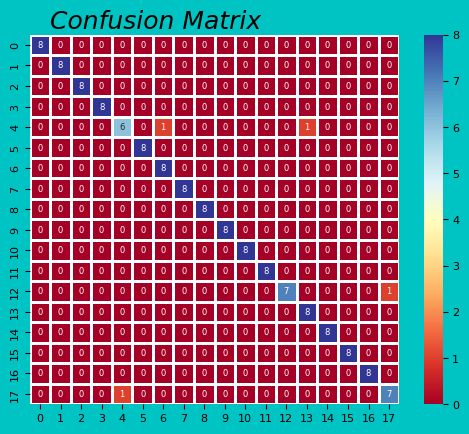

In [32]:
# confusion matrix
from sklearn.metrics import confusion_matrix
# accuracy: (tp + tn) / (p + n)
from sklearn.metrics import accuracy_score
# classification_report
from sklearn.metrics import classification_report
# kappa
from sklearn.metrics import cohen_kappa_score


true_labels = out_df['act_label']
predicted_labels = out_df['pred_label']

matrix = confusion_matrix(true_labels, predicted_labels)
print(matrix, '\n')

accuracy = accuracy_score(true_labels, predicted_labels)
print('Accuracy: %f' % accuracy, '\n')
print('Error rate: %f' % (1-accuracy), '\n')

# Generate classification report
report = classification_report(true_labels, predicted_labels)
print(report, '\n')

kappa = cohen_kappa_score(true_labels, predicted_labels)
print('Cohens kappa: %f' % kappa)



# Commented out IPython magic to ensure Python compatibility.
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

plt.rcParams['font.size'] = 8
bg_color = (0, 0.77, 0.77)
plt.rcParams['figure.facecolor'] = bg_color
plt.rcParams['axes.facecolor'] = bg_color

fig, ax = plt.subplots(1)

plt.text(1, -.3, "Confusion Matrix", fontsize = 18, color='Black', fontstyle='italic')

ax = sns.heatmap(matrix, annot=True, annot_kws={'size':6}, fmt="d",
                 robust=True, linewidths=.9, cmap="RdYlBu", square=True)
# vmin=0, vmax=350,
plt.savefig("Confusion_Matrix.jpeg", dpi=300, facecolor=bg_color, transparent=True)
plt.show()

# CR with BERT

In [33]:
# lib's
from transformers import BertModel, BertTokenizer
import torch
from sklearn.metrics.pairwise import cosine_similarity

import ast

In [34]:
# Vocabulary
vocabulary = ['cat', 'dog', 'blue_whale', 'chimpanzee', 'chimp', 'monkey',
              'bobcat', 'cow', 'dolphin', 'gorilla', 'killer_whale',
              'lion', 'mouse', 'ox', 'polar_bear', 'rabbit', 'rhinoceros',
              'siamese_cat', 'skunk', 'spider_monkey', 'squirrel',
              'tiger', 'walrus', 'giant_panda', 'giant', 'panda', 'bear',
              'seal', 'sealskin', 'walrus', 'rat']

In [35]:
def predict_with_bert(input_word, vocabulary, top_n=5):
    
    # Load pre-trained BERT model and tokenizer
    model_name = 'bert-base-uncased'
    tokenizer = BertTokenizer.from_pretrained(model_name)
    model = BertModel.from_pretrained(model_name)
    
    # Tokenize input word
    input_ids = tokenizer.encode(input_word, return_tensors='pt')
    
    # Get BERT embeddings for input word
    with torch.no_grad():
        outputs = model(input_ids)
        word_embedding = outputs.last_hidden_state.mean(dim=1).squeeze(0).numpy()
        
    # Compute cosine similarity with input word
    similarities = {}
    for word in vocabulary:
        # Tokenize and get embeddings for each word in the vocabulary
        word_ids = tokenizer.encode(word, return_tensors='pt')
        with torch.no_grad():
            outputs = model(word_ids)
            word_embedding_other = outputs.last_hidden_state.mean(dim=1).squeeze(0).numpy()

        # Compute cosine similarity
        similarity = cosine_similarity([word_embedding], [word_embedding_other])[0][0]
        similarities[word] = similarity

#     print(f"similarities : {similarities} \n")

    # Sort words by similarity
    similar_words = sorted(similarities, key=similarities.get, reverse=True)

    # Print top similar words
#     print("Top similar words to '{}':".format(input_word))
#     for word in similar_words[:10]:
#         print(word)

    return similar_words[:top_n]
    

In [41]:
# Load models
classification_model = load_model('CNN_GLCM_GABOR_model_h5.h5')
min_max_scaler_model = load(open(min_max_scaler_file, 'rb'))
class_labels = ['bear', 'blue_whale', 'bobcat', 'cow', 'dolphin', 'gorilla', 
                'killer_whale', 'lion', 'monkey', 'mouse', 'ox', 'rabbit', 
                'rhinoceros', 'siamese_cat', 'skunk', 'squirrel', 'tiger', 'walrus']

for label in class_labels:

    folder_name = label
    folder_path = os.path.join(VAL_DATA_PATH, folder_name, '*')

    image_path, image_label, pred_image_label, act_label, pred_label, similar_words = [], [], [], [], [], []

    for img_path in glob.glob(folder_path):
    # for img_path in glob.glob(r"test/*/*"):
        print(f"img_path : {img_path}")
        image_path.append(img_path)
        image_label.append(img_path.split('\\')[-2])
        act_label.append(class_labels.index(img_path.split('\\')[-2]))

        # Extract visual features using ResNet50
        visual_features = extract_visual_features(img_path)
    #     print(f"visual_features : {visual_features.shape} || {type(visual_features)}")

        # Compute texture features using GLCM
        GLCM_texture_feat = compute_GLCM_texture_features(img_path)
    #     GLCM_texture_features.append(GLCM_texture_feat)
    #     print(f"texture_features : {texture_features} || ")

        # Compute texture features using gabor
        gabor_texture_feat = compute_gabor_features(img_path)
    #     gabor_texture_features.append(gabor_texture_feat)
    #     print(f"texture_features : {texture_features}")

        # Concatenate visual and texture features
        l1 = visual_features[0].tolist()
        l2 = GLCM_texture_feat.tolist()
        l3 = gabor_texture_feat.tolist()
        l1.extend(l2)
        l1.extend(l3)
        combined_features = np.array(l1)
    #     print(f"combined_features : {combined_features}")

        # Normalize the features
        train_normalized_texture_features = min_max_scaler_model.transform([combined_features])
        train_normalized_texture_features_df = pd.DataFrame(train_normalized_texture_features)
    #     print(f"train_normalized_texture_features_df : {train_normalized_texture_features_df}")

    #     model.predict
        predicted_value = classification_model.predict(train_normalized_texture_features_df) # , verbos=0
        print(f"predicted_value : {np.argmax(predicted_value)} || {class_labels[np.argmax(predicted_value)]}")
        pred_image_label.append(class_labels[np.argmax(predicted_value)])
        pred_label.append(np.argmax(predicted_value))

        similar_words_bert = predict_with_bert(class_labels[np.argmax(predicted_value)], vocabulary) # class_labels
        print(f"similar_words_bert : {similar_words_bert}")
        similar_words.append(similar_words_bert)
    #     break

    out_df = pd.DataFrame({
        'image_path' : image_path, 
        'class_name' : image_label, 
        'pred_image_label' : pred_image_label, 
        'act_label' : act_label, 
        'pred_label' : pred_label,
        'similar_words' : similar_words
    })
    display(out_df.head())

    metadata_folder_name = 'CNN_GLCM_GABOR_BERT_metadata_with_BERT'
    os.makedirs(metadata_folder_name, exist_ok=True) 
    metadata_file_name = os.path.join(metadata_folder_name, folder_name + 'CNN_GLCM_GABOR_BERT_result.csv')
    out_df.to_csv(metadata_file_name, index = False)


img_path : ..\Dataset\artefact1\test\bear\bear_10001 (89).jpg


C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

1/1 [==============================] - 1s 506ms/step
predicted_value : 0 || bear
similar_words_bert : ['bear', 'rabbit', 'giant', 'tiger', 'cow']
img_path : ..\Dataset\artefact1\test\bear\bear_10001 (90).jpg


C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

1/1 [==============================] - 0s 89ms/step
predicted_value : 0 || bear
similar_words_bert : ['bear', 'rabbit', 'giant', 'tiger', 'cow']
img_path : ..\Dataset\artefact1\test\bear\bear_10001 (91).jpg


C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

1/1 [==============================] - 0s 31ms/step
predicted_value : 0 || bear
similar_words_bert : ['bear', 'rabbit', 'giant', 'tiger', 'cow']
img_path : ..\Dataset\artefact1\test\bear\bear_10001 (92).jpg


C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

1/1 [==============================] - 0s 30ms/step
predicted_value : 0 || bear
similar_words_bert : ['bear', 'rabbit', 'giant', 'tiger', 'cow']
img_path : ..\Dataset\artefact1\test\bear\bear_10001 (93).jpg


C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

1/1 [==============================] - 0s 40ms/step
predicted_value : 0 || bear
similar_words_bert : ['bear', 'rabbit', 'giant', 'tiger', 'cow']
img_path : ..\Dataset\artefact1\test\bear\bear_10001 (94).jpg


C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

1/1 [==============================] - 0s 34ms/step
predicted_value : 0 || bear
similar_words_bert : ['bear', 'rabbit', 'giant', 'tiger', 'cow']
img_path : ..\Dataset\artefact1\test\bear\bear_10001 (95).jpg


C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

1/1 [==============================] - 0s 51ms/step
predicted_value : 0 || bear
similar_words_bert : ['bear', 'rabbit', 'giant', 'tiger', 'cow']
img_path : ..\Dataset\artefact1\test\bear\bear_10001 (96).jpg


C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

1/1 [==============================] - 0s 49ms/step
predicted_value : 0 || bear
similar_words_bert : ['bear', 'rabbit', 'giant', 'tiger', 'cow']


image_path class_name  \
0  ..\Dataset\artefact1\test\bear\bear_10001 (89)...       bear   
1  ..\Dataset\artefact1\test\bear\bear_10001 (90)...       bear   
2  ..\Dataset\artefact1\test\bear\bear_10001 (91)...       bear   
3  ..\Dataset\artefact1\test\bear\bear_10001 (92)...       bear   
4  ..\Dataset\artefact1\test\bear\bear_10001 (93)...       bear   

  pred_image_label  act_label  pred_label                      similar_words  
0             bear          0           0  [bear, rabbit, giant, tiger, cow]  
1             bear          0           0  [bear, rabbit, giant, tiger, cow]  
2             bear          0           0  [bear, rabbit, giant, tiger, cow]  
3             bear          0           0  [bear, rabbit, giant, tiger, cow]  
4             bear          0           0  [bear, rabbit, giant, tiger, cow]

img_path : ..\Dataset\artefact1\test\blue_whale\blue+whale_10137.jpg


C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

1/1 [==============================] - 0s 30ms/step
predicted_value : 1 || blue_whale
similar_words_bert : ['blue_whale', 'killer_whale', 'polar_bear', 'giant_panda', 'spider_monkey']
img_path : ..\Dataset\artefact1\test\blue_whale\blue+whale_10139.jpg


C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

1/1 [==============================] - 0s 29ms/step
predicted_value : 1 || blue_whale
similar_words_bert : ['blue_whale', 'killer_whale', 'polar_bear', 'giant_panda', 'spider_monkey']
img_path : ..\Dataset\artefact1\test\blue_whale\blue+whale_10143.jpg


C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

1/1 [==============================] - 0s 28ms/step
predicted_value : 1 || blue_whale
similar_words_bert : ['blue_whale', 'killer_whale', 'polar_bear', 'giant_panda', 'spider_monkey']
img_path : ..\Dataset\artefact1\test\blue_whale\blue+whale_10150.jpg


C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

1/1 [==============================] - 0s 30ms/step
predicted_value : 1 || blue_whale
similar_words_bert : ['blue_whale', 'killer_whale', 'polar_bear', 'giant_panda', 'spider_monkey']
img_path : ..\Dataset\artefact1\test\blue_whale\blue+whale_10151.jpg


C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

1/1 [==============================] - 0s 28ms/step
predicted_value : 1 || blue_whale
similar_words_bert : ['blue_whale', 'killer_whale', 'polar_bear', 'giant_panda', 'spider_monkey']
img_path : ..\Dataset\artefact1\test\blue_whale\blue+whale_10152.jpg


C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

1/1 [==============================] - 0s 24ms/step
predicted_value : 1 || blue_whale
similar_words_bert : ['blue_whale', 'killer_whale', 'polar_bear', 'giant_panda', 'spider_monkey']
img_path : ..\Dataset\artefact1\test\blue_whale\blue+whale_10153.jpg


C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

1/1 [==============================] - 0s 26ms/step
predicted_value : 1 || blue_whale
similar_words_bert : ['blue_whale', 'killer_whale', 'polar_bear', 'giant_panda', 'spider_monkey']
img_path : ..\Dataset\artefact1\test\blue_whale\blue+whale_10154.jpg


C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

1/1 [==============================] - 0s 86ms/step
predicted_value : 1 || blue_whale
similar_words_bert : ['blue_whale', 'killer_whale', 'polar_bear', 'giant_panda', 'spider_monkey']


image_path  class_name  \
0  ..\Dataset\artefact1\test\blue_whale\blue+whal...  blue_whale   
1  ..\Dataset\artefact1\test\blue_whale\blue+whal...  blue_whale   
2  ..\Dataset\artefact1\test\blue_whale\blue+whal...  blue_whale   
3  ..\Dataset\artefact1\test\blue_whale\blue+whal...  blue_whale   
4  ..\Dataset\artefact1\test\blue_whale\blue+whal...  blue_whale   

  pred_image_label  act_label  pred_label  \
0       blue_whale          1           1   
1       blue_whale          1           1   
2       blue_whale          1           1   
3       blue_whale          1           1   
4       blue_whale          1           1   

                                       similar_words  
0  [blue_whale, killer_whale, polar_bear, giant_p...  
1  [blue_whale, killer_whale, polar_bear, giant_p...  
2  [blue_whale, killer_whale, polar_bear, giant_p...  
3  [blue_whale, killer_whale, polar_bear, giant_p...  
4  [blue_whale, killer_whale, polar_bear, giant_p...

img_path : ..\Dataset\artefact1\test\bobcat\bobcat_10067.jpg


C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

1/1 [==============================] - 0s 85ms/step
predicted_value : 2 || bobcat
similar_words_bert : ['bobcat', 'walrus', 'rhinoceros', 'chimp', 'sealskin']
img_path : ..\Dataset\artefact1\test\bobcat\bobcat_10068.jpg


C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

1/1 [==============================] - 0s 174ms/step
predicted_value : 2 || bobcat
similar_words_bert : ['bobcat', 'walrus', 'rhinoceros', 'chimp', 'sealskin']
img_path : ..\Dataset\artefact1\test\bobcat\bobcat_10069.jpg


C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

1/1 [==============================] - 0s 80ms/step
predicted_value : 2 || bobcat
similar_words_bert : ['bobcat', 'walrus', 'rhinoceros', 'chimp', 'sealskin']
img_path : ..\Dataset\artefact1\test\bobcat\bobcat_10070.jpg


C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

1/1 [==============================] - 0s 34ms/step
predicted_value : 2 || bobcat
similar_words_bert : ['bobcat', 'walrus', 'rhinoceros', 'chimp', 'sealskin']
img_path : ..\Dataset\artefact1\test\bobcat\bobcat_10071.jpg


C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

1/1 [==============================] - 0s 28ms/step
predicted_value : 2 || bobcat
similar_words_bert : ['bobcat', 'walrus', 'rhinoceros', 'chimp', 'sealskin']
img_path : ..\Dataset\artefact1\test\bobcat\bobcat_10072.jpg


C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

1/1 [==============================] - 0s 27ms/step
predicted_value : 2 || bobcat
similar_words_bert : ['bobcat', 'walrus', 'rhinoceros', 'chimp', 'sealskin']
img_path : ..\Dataset\artefact1\test\bobcat\bobcat_10073.jpg


C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

1/1 [==============================] - 0s 49ms/step
predicted_value : 2 || bobcat
similar_words_bert : ['bobcat', 'walrus', 'rhinoceros', 'chimp', 'sealskin']
img_path : ..\Dataset\artefact1\test\bobcat\bobcat_10074.jpg


C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

1/1 [==============================] - 0s 30ms/step
predicted_value : 2 || bobcat
similar_words_bert : ['bobcat', 'walrus', 'rhinoceros', 'chimp', 'sealskin']


image_path class_name  \
0  ..\Dataset\artefact1\test\bobcat\bobcat_10067.jpg     bobcat   
1  ..\Dataset\artefact1\test\bobcat\bobcat_10068.jpg     bobcat   
2  ..\Dataset\artefact1\test\bobcat\bobcat_10069.jpg     bobcat   
3  ..\Dataset\artefact1\test\bobcat\bobcat_10070.jpg     bobcat   
4  ..\Dataset\artefact1\test\bobcat\bobcat_10071.jpg     bobcat   

  pred_image_label  act_label  pred_label  \
0           bobcat          2           2   
1           bobcat          2           2   
2           bobcat          2           2   
3           bobcat          2           2   
4           bobcat          2           2   

                                   similar_words  
0  [bobcat, walrus, rhinoceros, chimp, sealskin]  
1  [bobcat, walrus, rhinoceros, chimp, sealskin]  
2  [bobcat, walrus, rhinoceros, chimp, sealskin]  
3  [bobcat, walrus, rhinoceros, chimp, sealskin]  
4  [bobcat, walrus, rhinoceros, chimp, sealskin]

img_path : ..\Dataset\artefact1\test\cow\cow_10090.jpg


C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

1/1 [==============================] - 0s 31ms/step
predicted_value : 3 || cow
similar_words_bert : ['cow', 'rabbit', 'squirrel', 'bear', 'panda']
img_path : ..\Dataset\artefact1\test\cow\cow_10091.jpg


C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

1/1 [==============================] - 0s 29ms/step
predicted_value : 3 || cow
similar_words_bert : ['cow', 'rabbit', 'squirrel', 'bear', 'panda']
img_path : ..\Dataset\artefact1\test\cow\cow_10092.jpg


C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

1/1 [==============================] - 0s 29ms/step
predicted_value : 3 || cow
similar_words_bert : ['cow', 'rabbit', 'squirrel', 'bear', 'panda']
img_path : ..\Dataset\artefact1\test\cow\cow_10093.jpg


C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

1/1 [==============================] - 0s 25ms/step
predicted_value : 3 || cow
similar_words_bert : ['cow', 'rabbit', 'squirrel', 'bear', 'panda']
img_path : ..\Dataset\artefact1\test\cow\cow_10094.jpg


C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

1/1 [==============================] - 0s 31ms/step
predicted_value : 3 || cow
similar_words_bert : ['cow', 'rabbit', 'squirrel', 'bear', 'panda']
img_path : ..\Dataset\artefact1\test\cow\cow_10095.jpg


C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

1/1 [==============================] - 0s 28ms/step
predicted_value : 3 || cow
similar_words_bert : ['cow', 'rabbit', 'squirrel', 'bear', 'panda']
img_path : ..\Dataset\artefact1\test\cow\cow_10096.jpg


C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

1/1 [==============================] - 0s 34ms/step
predicted_value : 3 || cow
similar_words_bert : ['cow', 'rabbit', 'squirrel', 'bear', 'panda']
img_path : ..\Dataset\artefact1\test\cow\cow_10097.jpg


C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

1/1 [==============================] - 0s 27ms/step
predicted_value : 3 || cow
similar_words_bert : ['cow', 'rabbit', 'squirrel', 'bear', 'panda']


image_path class_name pred_image_label  \
0  ..\Dataset\artefact1\test\cow\cow_10090.jpg        cow              cow   
1  ..\Dataset\artefact1\test\cow\cow_10091.jpg        cow              cow   
2  ..\Dataset\artefact1\test\cow\cow_10092.jpg        cow              cow   
3  ..\Dataset\artefact1\test\cow\cow_10093.jpg        cow              cow   
4  ..\Dataset\artefact1\test\cow\cow_10094.jpg        cow              cow   

   act_label  pred_label                         similar_words  
0          3           3  [cow, rabbit, squirrel, bear, panda]  
1          3           3  [cow, rabbit, squirrel, bear, panda]  
2          3           3  [cow, rabbit, squirrel, bear, panda]  
3          3           3  [cow, rabbit, squirrel, bear, panda]  
4          3           3  [cow, rabbit, squirrel, bear, panda]

img_path : ..\Dataset\artefact1\test\dolphin\dolphin_10078.jpg


C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

1/1 [==============================] - 0s 30ms/step
predicted_value : 6 || killer_whale
similar_words_bert : ['killer_whale', 'blue_whale', 'polar_bear', 'giant_panda', 'spider_monkey']
img_path : ..\Dataset\artefact1\test\dolphin\dolphin_10079.jpg


C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

1/1 [==============================] - 0s 28ms/step
predicted_value : 4 || dolphin
similar_words_bert : ['dolphin', 'lion', 'monkey', 'squirrel', 'dog']
img_path : ..\Dataset\artefact1\test\dolphin\dolphin_10080.jpg


C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

1/1 [==============================] - 0s 29ms/step
predicted_value : 13 || siamese_cat
similar_words_bert : ['siamese_cat', 'polar_bear', 'giant_panda', 'blue_whale', 'spider_monkey']
img_path : ..\Dataset\artefact1\test\dolphin\dolphin_10081.jpg


C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

1/1 [==============================] - 0s 30ms/step
predicted_value : 4 || dolphin
similar_words_bert : ['dolphin', 'lion', 'monkey', 'squirrel', 'dog']
img_path : ..\Dataset\artefact1\test\dolphin\dolphin_10082.jpg


C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

1/1 [==============================] - 0s 109ms/step
predicted_value : 4 || dolphin
similar_words_bert : ['dolphin', 'lion', 'monkey', 'squirrel', 'dog']
img_path : ..\Dataset\artefact1\test\dolphin\dolphin_10083.jpg


C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

1/1 [==============================] - 0s 28ms/step
predicted_value : 4 || dolphin
similar_words_bert : ['dolphin', 'lion', 'monkey', 'squirrel', 'dog']
img_path : ..\Dataset\artefact1\test\dolphin\dolphin_10084.jpg


C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

1/1 [==============================] - 0s 33ms/step
predicted_value : 4 || dolphin
similar_words_bert : ['dolphin', 'lion', 'monkey', 'squirrel', 'dog']
img_path : ..\Dataset\artefact1\test\dolphin\dolphin_10085.jpg


C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

1/1 [==============================] - 0s 40ms/step
predicted_value : 4 || dolphin
similar_words_bert : ['dolphin', 'lion', 'monkey', 'squirrel', 'dog']


image_path class_name  \
0  ..\Dataset\artefact1\test\dolphin\dolphin_1007...    dolphin   
1  ..\Dataset\artefact1\test\dolphin\dolphin_1007...    dolphin   
2  ..\Dataset\artefact1\test\dolphin\dolphin_1008...    dolphin   
3  ..\Dataset\artefact1\test\dolphin\dolphin_1008...    dolphin   
4  ..\Dataset\artefact1\test\dolphin\dolphin_1008...    dolphin   

  pred_image_label  act_label  pred_label  \
0     killer_whale          4           6   
1          dolphin          4           4   
2      siamese_cat          4          13   
3          dolphin          4           4   
4          dolphin          4           4   

                                       similar_words  
0  [killer_whale, blue_whale, polar_bear, giant_p...  
1             [dolphin, lion, monkey, squirrel, dog]  
2  [siamese_cat, polar_bear, giant_panda, blue_wh...  
3             [dolphin, lion, monkey, squirrel, dog]  
4             [dolphin, lion, monkey, squirrel, dog]

img_path : ..\Dataset\artefact1\test\gorilla\gorilla_10122.jpg


C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

1/1 [==============================] - 0s 28ms/step
predicted_value : 5 || gorilla
similar_words_bert : ['gorilla', 'tiger', 'mouse', 'panda', 'bear']
img_path : ..\Dataset\artefact1\test\gorilla\gorilla_10123.jpg


C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

1/1 [==============================] - 0s 39ms/step
predicted_value : 5 || gorilla
similar_words_bert : ['gorilla', 'tiger', 'mouse', 'panda', 'bear']
img_path : ..\Dataset\artefact1\test\gorilla\gorilla_10124.jpg


C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

1/1 [==============================] - 0s 39ms/step
predicted_value : 5 || gorilla
similar_words_bert : ['gorilla', 'tiger', 'mouse', 'panda', 'bear']
img_path : ..\Dataset\artefact1\test\gorilla\gorilla_10125.jpg


C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

1/1 [==============================] - 0s 36ms/step
predicted_value : 5 || gorilla
similar_words_bert : ['gorilla', 'tiger', 'mouse', 'panda', 'bear']
img_path : ..\Dataset\artefact1\test\gorilla\gorilla_10126.jpg


C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

1/1 [==============================] - 0s 114ms/step
predicted_value : 5 || gorilla
similar_words_bert : ['gorilla', 'tiger', 'mouse', 'panda', 'bear']
img_path : ..\Dataset\artefact1\test\gorilla\gorilla_10127.jpg


C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

1/1 [==============================] - 0s 31ms/step
predicted_value : 5 || gorilla
similar_words_bert : ['gorilla', 'tiger', 'mouse', 'panda', 'bear']
img_path : ..\Dataset\artefact1\test\gorilla\gorilla_10128.jpg


C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

1/1 [==============================] - 0s 29ms/step
predicted_value : 5 || gorilla
similar_words_bert : ['gorilla', 'tiger', 'mouse', 'panda', 'bear']
img_path : ..\Dataset\artefact1\test\gorilla\gorilla_10129.jpg


C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

1/1 [==============================] - 0s 29ms/step
predicted_value : 5 || gorilla
similar_words_bert : ['gorilla', 'tiger', 'mouse', 'panda', 'bear']


image_path class_name  \
0  ..\Dataset\artefact1\test\gorilla\gorilla_1012...    gorilla   
1  ..\Dataset\artefact1\test\gorilla\gorilla_1012...    gorilla   
2  ..\Dataset\artefact1\test\gorilla\gorilla_1012...    gorilla   
3  ..\Dataset\artefact1\test\gorilla\gorilla_1012...    gorilla   
4  ..\Dataset\artefact1\test\gorilla\gorilla_1012...    gorilla   

  pred_image_label  act_label  pred_label  \
0          gorilla          5           5   
1          gorilla          5           5   
2          gorilla          5           5   
3          gorilla          5           5   
4          gorilla          5           5   

                          similar_words  
0  [gorilla, tiger, mouse, panda, bear]  
1  [gorilla, tiger, mouse, panda, bear]  
2  [gorilla, tiger, mouse, panda, bear]  
3  [gorilla, tiger, mouse, panda, bear]  
4  [gorilla, tiger, mouse, panda, bear]

img_path : ..\Dataset\artefact1\test\killer_whale\killer+whale_10122.jpg


C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

1/1 [==============================] - 0s 25ms/step
predicted_value : 6 || killer_whale
similar_words_bert : ['killer_whale', 'blue_whale', 'polar_bear', 'giant_panda', 'spider_monkey']
img_path : ..\Dataset\artefact1\test\killer_whale\killer+whale_10123.jpg


C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

1/1 [==============================] - 0s 29ms/step
predicted_value : 6 || killer_whale
similar_words_bert : ['killer_whale', 'blue_whale', 'polar_bear', 'giant_panda', 'spider_monkey']
img_path : ..\Dataset\artefact1\test\killer_whale\killer+whale_10124.jpg


C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

1/1 [==============================] - 0s 30ms/step
predicted_value : 6 || killer_whale
similar_words_bert : ['killer_whale', 'blue_whale', 'polar_bear', 'giant_panda', 'spider_monkey']
img_path : ..\Dataset\artefact1\test\killer_whale\killer+whale_10125.jpg


C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

1/1 [==============================] - 0s 30ms/step
predicted_value : 6 || killer_whale
similar_words_bert : ['killer_whale', 'blue_whale', 'polar_bear', 'giant_panda', 'spider_monkey']
img_path : ..\Dataset\artefact1\test\killer_whale\killer+whale_10126.jpg


C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

1/1 [==============================] - 0s 42ms/step
predicted_value : 6 || killer_whale
similar_words_bert : ['killer_whale', 'blue_whale', 'polar_bear', 'giant_panda', 'spider_monkey']
img_path : ..\Dataset\artefact1\test\killer_whale\killer+whale_10127.jpg


C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

1/1 [==============================] - 0s 27ms/step
predicted_value : 6 || killer_whale
similar_words_bert : ['killer_whale', 'blue_whale', 'polar_bear', 'giant_panda', 'spider_monkey']
img_path : ..\Dataset\artefact1\test\killer_whale\killer+whale_10128.jpg


C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

1/1 [==============================] - 0s 32ms/step
predicted_value : 6 || killer_whale
similar_words_bert : ['killer_whale', 'blue_whale', 'polar_bear', 'giant_panda', 'spider_monkey']
img_path : ..\Dataset\artefact1\test\killer_whale\killer+whale_10129.jpg


C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

1/1 [==============================] - 0s 36ms/step
predicted_value : 6 || killer_whale
similar_words_bert : ['killer_whale', 'blue_whale', 'polar_bear', 'giant_panda', 'spider_monkey']


image_path    class_name  \
0  ..\Dataset\artefact1\test\killer_whale\killer+...  killer_whale   
1  ..\Dataset\artefact1\test\killer_whale\killer+...  killer_whale   
2  ..\Dataset\artefact1\test\killer_whale\killer+...  killer_whale   
3  ..\Dataset\artefact1\test\killer_whale\killer+...  killer_whale   
4  ..\Dataset\artefact1\test\killer_whale\killer+...  killer_whale   

  pred_image_label  act_label  pred_label  \
0     killer_whale          6           6   
1     killer_whale          6           6   
2     killer_whale          6           6   
3     killer_whale          6           6   
4     killer_whale          6           6   

                                       similar_words  
0  [killer_whale, blue_whale, polar_bear, giant_p...  
1  [killer_whale, blue_whale, polar_bear, giant_p...  
2  [killer_whale, blue_whale, polar_bear, giant_p...  
3  [killer_whale, blue_whale, polar_bear, giant_p...  
4  [killer_whale, blue_whale, polar_bear, giant_p...

img_path : ..\Dataset\artefact1\test\lion\lion_10067.jpg


C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

1/1 [==============================] - 0s 29ms/step
predicted_value : 7 || lion
similar_words_bert : ['lion', 'squirrel', 'giant', 'monkey', 'rabbit']
img_path : ..\Dataset\artefact1\test\lion\lion_10068.jpg


C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

1/1 [==============================] - 0s 31ms/step
predicted_value : 7 || lion
similar_words_bert : ['lion', 'squirrel', 'giant', 'monkey', 'rabbit']
img_path : ..\Dataset\artefact1\test\lion\lion_10069.jpg


C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

1/1 [==============================] - 0s 31ms/step
predicted_value : 7 || lion
similar_words_bert : ['lion', 'squirrel', 'giant', 'monkey', 'rabbit']
img_path : ..\Dataset\artefact1\test\lion\lion_10070.jpg


C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

1/1 [==============================] - 0s 26ms/step
predicted_value : 7 || lion
similar_words_bert : ['lion', 'squirrel', 'giant', 'monkey', 'rabbit']
img_path : ..\Dataset\artefact1\test\lion\lion_10071.jpg


C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

1/1 [==============================] - 0s 32ms/step
predicted_value : 7 || lion
similar_words_bert : ['lion', 'squirrel', 'giant', 'monkey', 'rabbit']
img_path : ..\Dataset\artefact1\test\lion\lion_10072.jpg


C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

1/1 [==============================] - 0s 92ms/step
predicted_value : 7 || lion
similar_words_bert : ['lion', 'squirrel', 'giant', 'monkey', 'rabbit']
img_path : ..\Dataset\artefact1\test\lion\lion_10073.jpg


C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be remov

1/1 [==============================] - 0s 27ms/step
predicted_value : 7 || lion
similar_words_bert : ['lion', 'squirrel', 'giant', 'monkey', 'rabbit']
img_path : ..\Dataset\artefact1\test\lion\lion_10074.jpg


C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

1/1 [==============================] - 0s 31ms/step
predicted_value : 7 || lion
similar_words_bert : ['lion', 'squirrel', 'giant', 'monkey', 'rabbit']


image_path class_name pred_image_label  \
0  ..\Dataset\artefact1\test\lion\lion_10067.jpg       lion             lion   
1  ..\Dataset\artefact1\test\lion\lion_10068.jpg       lion             lion   
2  ..\Dataset\artefact1\test\lion\lion_10069.jpg       lion             lion   
3  ..\Dataset\artefact1\test\lion\lion_10070.jpg       lion             lion   
4  ..\Dataset\artefact1\test\lion\lion_10071.jpg       lion             lion   

   act_label  pred_label                            similar_words  
0          7           7  [lion, squirrel, giant, monkey, rabbit]  
1          7           7  [lion, squirrel, giant, monkey, rabbit]  
2          7           7  [lion, squirrel, giant, monkey, rabbit]  
3          7           7  [lion, squirrel, giant, monkey, rabbit]  
4          7           7  [lion, squirrel, giant, monkey, rabbit]

img_path : ..\Dataset\artefact1\test\monkey\monkey_10003 (190).jpg


C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

1/1 [==============================] - 0s 44ms/step
predicted_value : 8 || monkey
similar_words_bert : ['monkey', 'squirrel', 'rabbit', 'lion', 'tiger']
img_path : ..\Dataset\artefact1\test\monkey\monkey_10003 (191).jpg


C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

1/1 [==============================] - 0s 29ms/step
predicted_value : 8 || monkey
similar_words_bert : ['monkey', 'squirrel', 'rabbit', 'lion', 'tiger']
img_path : ..\Dataset\artefact1\test\monkey\monkey_10003 (192).jpg


C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

1/1 [==============================] - 0s 324ms/step
predicted_value : 8 || monkey
similar_words_bert : ['monkey', 'squirrel', 'rabbit', 'lion', 'tiger']
img_path : ..\Dataset\artefact1\test\monkey\monkey_10003 (193).jpg


C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

1/1 [==============================] - 0s 110ms/step
predicted_value : 8 || monkey
similar_words_bert : ['monkey', 'squirrel', 'rabbit', 'lion', 'tiger']
img_path : ..\Dataset\artefact1\test\monkey\monkey_10003 (194).jpg


C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

1/1 [==============================] - 0s 36ms/step
predicted_value : 8 || monkey
similar_words_bert : ['monkey', 'squirrel', 'rabbit', 'lion', 'tiger']
img_path : ..\Dataset\artefact1\test\monkey\monkey_10003 (195).jpg


C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

1/1 [==============================] - 0s 31ms/step
predicted_value : 8 || monkey
similar_words_bert : ['monkey', 'squirrel', 'rabbit', 'lion', 'tiger']
img_path : ..\Dataset\artefact1\test\monkey\monkey_10003 (196).jpg


C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

1/1 [==============================] - 0s 25ms/step
predicted_value : 8 || monkey
similar_words_bert : ['monkey', 'squirrel', 'rabbit', 'lion', 'tiger']
img_path : ..\Dataset\artefact1\test\monkey\monkey_10003 (197).jpg


C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

1/1 [==============================] - 0s 27ms/step
predicted_value : 8 || monkey
similar_words_bert : ['monkey', 'squirrel', 'rabbit', 'lion', 'tiger']


image_path class_name  \
0  ..\Dataset\artefact1\test\monkey\monkey_10003 ...     monkey   
1  ..\Dataset\artefact1\test\monkey\monkey_10003 ...     monkey   
2  ..\Dataset\artefact1\test\monkey\monkey_10003 ...     monkey   
3  ..\Dataset\artefact1\test\monkey\monkey_10003 ...     monkey   
4  ..\Dataset\artefact1\test\monkey\monkey_10003 ...     monkey   

  pred_image_label  act_label  pred_label  \
0           monkey          8           8   
1           monkey          8           8   
2           monkey          8           8   
3           monkey          8           8   
4           monkey          8           8   

                             similar_words  
0  [monkey, squirrel, rabbit, lion, tiger]  
1  [monkey, squirrel, rabbit, lion, tiger]  
2  [monkey, squirrel, rabbit, lion, tiger]  
3  [monkey, squirrel, rabbit, lion, tiger]  
4  [monkey, squirrel, rabbit, lion, tiger]

img_path : ..\Dataset\artefact1\test\mouse\mouse_10097.jpg


C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

1/1 [==============================] - 0s 25ms/step
predicted_value : 9 || mouse
similar_words_bert : ['mouse', 'rabbit', 'squirrel', 'bear', 'gorilla']
img_path : ..\Dataset\artefact1\test\mouse\mouse_10098.jpg


C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

1/1 [==============================] - 0s 30ms/step
predicted_value : 9 || mouse
similar_words_bert : ['mouse', 'rabbit', 'squirrel', 'bear', 'gorilla']
img_path : ..\Dataset\artefact1\test\mouse\mouse_10099.jpg


C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

1/1 [==============================] - 0s 36ms/step
predicted_value : 9 || mouse
similar_words_bert : ['mouse', 'rabbit', 'squirrel', 'bear', 'gorilla']
img_path : ..\Dataset\artefact1\test\mouse\mouse_10100.jpg


C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

1/1 [==============================] - 0s 37ms/step
predicted_value : 9 || mouse
similar_words_bert : ['mouse', 'rabbit', 'squirrel', 'bear', 'gorilla']
img_path : ..\Dataset\artefact1\test\mouse\mouse_10101.jpg


C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

1/1 [==============================] - 0s 33ms/step
predicted_value : 9 || mouse
similar_words_bert : ['mouse', 'rabbit', 'squirrel', 'bear', 'gorilla']
img_path : ..\Dataset\artefact1\test\mouse\mouse_10102.jpg


C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

1/1 [==============================] - 0s 27ms/step
predicted_value : 9 || mouse
similar_words_bert : ['mouse', 'rabbit', 'squirrel', 'bear', 'gorilla']
img_path : ..\Dataset\artefact1\test\mouse\mouse_10103.jpg


C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

1/1 [==============================] - 0s 30ms/step
predicted_value : 9 || mouse
similar_words_bert : ['mouse', 'rabbit', 'squirrel', 'bear', 'gorilla']
img_path : ..\Dataset\artefact1\test\mouse\mouse_10104.jpg


C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

1/1 [==============================] - 0s 28ms/step
predicted_value : 9 || mouse
similar_words_bert : ['mouse', 'rabbit', 'squirrel', 'bear', 'gorilla']


image_path class_name  \
0  ..\Dataset\artefact1\test\mouse\mouse_10097.jpg      mouse   
1  ..\Dataset\artefact1\test\mouse\mouse_10098.jpg      mouse   
2  ..\Dataset\artefact1\test\mouse\mouse_10099.jpg      mouse   
3  ..\Dataset\artefact1\test\mouse\mouse_10100.jpg      mouse   
4  ..\Dataset\artefact1\test\mouse\mouse_10101.jpg      mouse   

  pred_image_label  act_label  pred_label  \
0            mouse          9           9   
1            mouse          9           9   
2            mouse          9           9   
3            mouse          9           9   
4            mouse          9           9   

                              similar_words  
0  [mouse, rabbit, squirrel, bear, gorilla]  
1  [mouse, rabbit, squirrel, bear, gorilla]  
2  [mouse, rabbit, squirrel, bear, gorilla]  
3  [mouse, rabbit, squirrel, bear, gorilla]  
4  [mouse, rabbit, squirrel, bear, gorilla]

img_path : ..\Dataset\artefact1\test\ox\ox_10119.jpg


C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

1/1 [==============================] - 0s 25ms/step
predicted_value : 10 || ox
similar_words_bert : ['ox', 'mouse', 'cow', 'rabbit', 'bear']
img_path : ..\Dataset\artefact1\test\ox\ox_10120.jpg


C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

1/1 [==============================] - 0s 41ms/step
predicted_value : 10 || ox
similar_words_bert : ['ox', 'mouse', 'cow', 'rabbit', 'bear']
img_path : ..\Dataset\artefact1\test\ox\ox_10121.jpg


C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

1/1 [==============================] - 0s 25ms/step
predicted_value : 10 || ox
similar_words_bert : ['ox', 'mouse', 'cow', 'rabbit', 'bear']
img_path : ..\Dataset\artefact1\test\ox\ox_10122.jpg


C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

1/1 [==============================] - 0s 30ms/step
predicted_value : 10 || ox
similar_words_bert : ['ox', 'mouse', 'cow', 'rabbit', 'bear']
img_path : ..\Dataset\artefact1\test\ox\ox_10123.jpg


C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

1/1 [==============================] - 0s 33ms/step
predicted_value : 10 || ox
similar_words_bert : ['ox', 'mouse', 'cow', 'rabbit', 'bear']
img_path : ..\Dataset\artefact1\test\ox\ox_10124.jpg


C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

1/1 [==============================] - 0s 28ms/step
predicted_value : 10 || ox
similar_words_bert : ['ox', 'mouse', 'cow', 'rabbit', 'bear']
img_path : ..\Dataset\artefact1\test\ox\ox_10125.jpg


C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

1/1 [==============================] - 0s 33ms/step
predicted_value : 10 || ox
similar_words_bert : ['ox', 'mouse', 'cow', 'rabbit', 'bear']
img_path : ..\Dataset\artefact1\test\ox\ox_10126.jpg


C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

1/1 [==============================] - 0s 31ms/step
predicted_value : 10 || ox
similar_words_bert : ['ox', 'mouse', 'cow', 'rabbit', 'bear']


image_path class_name pred_image_label  \
0  ..\Dataset\artefact1\test\ox\ox_10119.jpg         ox               ox   
1  ..\Dataset\artefact1\test\ox\ox_10120.jpg         ox               ox   
2  ..\Dataset\artefact1\test\ox\ox_10121.jpg         ox               ox   
3  ..\Dataset\artefact1\test\ox\ox_10122.jpg         ox               ox   
4  ..\Dataset\artefact1\test\ox\ox_10123.jpg         ox               ox   

   act_label  pred_label                   similar_words  
0         10          10  [ox, mouse, cow, rabbit, bear]  
1         10          10  [ox, mouse, cow, rabbit, bear]  
2         10          10  [ox, mouse, cow, rabbit, bear]  
3         10          10  [ox, mouse, cow, rabbit, bear]  
4         10          10  [ox, mouse, cow, rabbit, bear]

img_path : ..\Dataset\artefact1\test\rabbit\rabbit_10045.jpg


C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

1/1 [==============================] - 0s 28ms/step
predicted_value : 11 || rabbit
similar_words_bert : ['rabbit', 'squirrel', 'monkey', 'tiger', 'lion']
img_path : ..\Dataset\artefact1\test\rabbit\rabbit_10046.jpg


C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

1/1 [==============================] - 0s 28ms/step
predicted_value : 11 || rabbit
similar_words_bert : ['rabbit', 'squirrel', 'monkey', 'tiger', 'lion']
img_path : ..\Dataset\artefact1\test\rabbit\rabbit_10047.jpg


C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

1/1 [==============================] - 0s 28ms/step
predicted_value : 11 || rabbit
similar_words_bert : ['rabbit', 'squirrel', 'monkey', 'tiger', 'lion']
img_path : ..\Dataset\artefact1\test\rabbit\rabbit_10048.jpg


C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

1/1 [==============================] - 0s 31ms/step
predicted_value : 11 || rabbit
similar_words_bert : ['rabbit', 'squirrel', 'monkey', 'tiger', 'lion']
img_path : ..\Dataset\artefact1\test\rabbit\rabbit_10049.jpg


C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

1/1 [==============================] - 0s 26ms/step
predicted_value : 11 || rabbit
similar_words_bert : ['rabbit', 'squirrel', 'monkey', 'tiger', 'lion']
img_path : ..\Dataset\artefact1\test\rabbit\rabbit_10050.jpg


C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

1/1 [==============================] - 0s 33ms/step
predicted_value : 11 || rabbit
similar_words_bert : ['rabbit', 'squirrel', 'monkey', 'tiger', 'lion']
img_path : ..\Dataset\artefact1\test\rabbit\rabbit_10051.jpg


C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

1/1 [==============================] - 0s 31ms/step
predicted_value : 11 || rabbit
similar_words_bert : ['rabbit', 'squirrel', 'monkey', 'tiger', 'lion']
img_path : ..\Dataset\artefact1\test\rabbit\rabbit_10052.jpg


C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

1/1 [==============================] - 0s 48ms/step
predicted_value : 11 || rabbit
similar_words_bert : ['rabbit', 'squirrel', 'monkey', 'tiger', 'lion']


image_path class_name  \
0  ..\Dataset\artefact1\test\rabbit\rabbit_10045.jpg     rabbit   
1  ..\Dataset\artefact1\test\rabbit\rabbit_10046.jpg     rabbit   
2  ..\Dataset\artefact1\test\rabbit\rabbit_10047.jpg     rabbit   
3  ..\Dataset\artefact1\test\rabbit\rabbit_10048.jpg     rabbit   
4  ..\Dataset\artefact1\test\rabbit\rabbit_10049.jpg     rabbit   

  pred_image_label  act_label  pred_label  \
0           rabbit         11          11   
1           rabbit         11          11   
2           rabbit         11          11   
3           rabbit         11          11   
4           rabbit         11          11   

                             similar_words  
0  [rabbit, squirrel, monkey, tiger, lion]  
1  [rabbit, squirrel, monkey, tiger, lion]  
2  [rabbit, squirrel, monkey, tiger, lion]  
3  [rabbit, squirrel, monkey, tiger, lion]  
4  [rabbit, squirrel, monkey, tiger, lion]

img_path : ..\Dataset\artefact1\test\rhinoceros\rhinoceros_10042.jpg


C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

1/1 [==============================] - 0s 32ms/step
predicted_value : 12 || rhinoceros
similar_words_bert : ['rhinoceros', 'walrus', 'bobcat', 'chimpanzee', 'chimp']
img_path : ..\Dataset\artefact1\test\rhinoceros\rhinoceros_10043.jpg


C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

1/1 [==============================] - 0s 28ms/step
predicted_value : 12 || rhinoceros
similar_words_bert : ['rhinoceros', 'walrus', 'bobcat', 'chimpanzee', 'chimp']
img_path : ..\Dataset\artefact1\test\rhinoceros\rhinoceros_10044.jpg


C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

1/1 [==============================] - 0s 28ms/step
predicted_value : 12 || rhinoceros
similar_words_bert : ['rhinoceros', 'walrus', 'bobcat', 'chimpanzee', 'chimp']
img_path : ..\Dataset\artefact1\test\rhinoceros\rhinoceros_10045.jpg


C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

1/1 [==============================] - 0s 31ms/step
predicted_value : 12 || rhinoceros
similar_words_bert : ['rhinoceros', 'walrus', 'bobcat', 'chimpanzee', 'chimp']
img_path : ..\Dataset\artefact1\test\rhinoceros\rhinoceros_10046.jpg


C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

1/1 [==============================] - 0s 31ms/step
predicted_value : 12 || rhinoceros
similar_words_bert : ['rhinoceros', 'walrus', 'bobcat', 'chimpanzee', 'chimp']
img_path : ..\Dataset\artefact1\test\rhinoceros\rhinoceros_10047.jpg


C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

1/1 [==============================] - 0s 37ms/step
predicted_value : 12 || rhinoceros
similar_words_bert : ['rhinoceros', 'walrus', 'bobcat', 'chimpanzee', 'chimp']
img_path : ..\Dataset\artefact1\test\rhinoceros\rhinoceros_10048.jpg


C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

1/1 [==============================] - 0s 45ms/step
predicted_value : 17 || walrus
similar_words_bert : ['walrus', 'chimp', 'bobcat', 'lion', 'rhinoceros']
img_path : ..\Dataset\artefact1\test\rhinoceros\rhinoceros_10049.jpg


C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

1/1 [==============================] - 0s 34ms/step
predicted_value : 12 || rhinoceros
similar_words_bert : ['rhinoceros', 'walrus', 'bobcat', 'chimpanzee', 'chimp']


image_path  class_name  \
0  ..\Dataset\artefact1\test\rhinoceros\rhinocero...  rhinoceros   
1  ..\Dataset\artefact1\test\rhinoceros\rhinocero...  rhinoceros   
2  ..\Dataset\artefact1\test\rhinoceros\rhinocero...  rhinoceros   
3  ..\Dataset\artefact1\test\rhinoceros\rhinocero...  rhinoceros   
4  ..\Dataset\artefact1\test\rhinoceros\rhinocero...  rhinoceros   

  pred_image_label  act_label  pred_label  \
0       rhinoceros         12          12   
1       rhinoceros         12          12   
2       rhinoceros         12          12   
3       rhinoceros         12          12   
4       rhinoceros         12          12   

                                     similar_words  
0  [rhinoceros, walrus, bobcat, chimpanzee, chimp]  
1  [rhinoceros, walrus, bobcat, chimpanzee, chimp]  
2  [rhinoceros, walrus, bobcat, chimpanzee, chimp]  
3  [rhinoceros, walrus, bobcat, chimpanzee, chimp]  
4  [rhinoceros, walrus, bobcat, chimpanzee, chimp]

img_path : ..\Dataset\artefact1\test\siamese_cat\siamese+cat_10196.jpg


C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

1/1 [==============================] - 0s 26ms/step
predicted_value : 13 || siamese_cat
similar_words_bert : ['siamese_cat', 'polar_bear', 'giant_panda', 'blue_whale', 'spider_monkey']
img_path : ..\Dataset\artefact1\test\siamese_cat\siamese+cat_10197.jpg


C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

1/1 [==============================] - 0s 27ms/step
predicted_value : 13 || siamese_cat
similar_words_bert : ['siamese_cat', 'polar_bear', 'giant_panda', 'blue_whale', 'spider_monkey']
img_path : ..\Dataset\artefact1\test\siamese_cat\siamese+cat_10198.jpg


C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

1/1 [==============================] - 0s 27ms/step
predicted_value : 13 || siamese_cat
similar_words_bert : ['siamese_cat', 'polar_bear', 'giant_panda', 'blue_whale', 'spider_monkey']
img_path : ..\Dataset\artefact1\test\siamese_cat\siamese+cat_10199.jpg


C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

1/1 [==============================] - 0s 26ms/step
predicted_value : 13 || siamese_cat
similar_words_bert : ['siamese_cat', 'polar_bear', 'giant_panda', 'blue_whale', 'spider_monkey']
img_path : ..\Dataset\artefact1\test\siamese_cat\siamese+cat_10200.jpg


C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

1/1 [==============================] - 0s 33ms/step
predicted_value : 13 || siamese_cat
similar_words_bert : ['siamese_cat', 'polar_bear', 'giant_panda', 'blue_whale', 'spider_monkey']
img_path : ..\Dataset\artefact1\test\siamese_cat\siamese+cat_10201.jpg


C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

1/1 [==============================] - 0s 27ms/step
predicted_value : 13 || siamese_cat
similar_words_bert : ['siamese_cat', 'polar_bear', 'giant_panda', 'blue_whale', 'spider_monkey']
img_path : ..\Dataset\artefact1\test\siamese_cat\siamese+cat_10202.jpg


C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

1/1 [==============================] - 0s 37ms/step
predicted_value : 13 || siamese_cat
similar_words_bert : ['siamese_cat', 'polar_bear', 'giant_panda', 'blue_whale', 'spider_monkey']
img_path : ..\Dataset\artefact1\test\siamese_cat\siamese+cat_10203.jpg


C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

1/1 [==============================] - 0s 32ms/step
predicted_value : 13 || siamese_cat
similar_words_bert : ['siamese_cat', 'polar_bear', 'giant_panda', 'blue_whale', 'spider_monkey']


image_path   class_name  \
0  ..\Dataset\artefact1\test\siamese_cat\siamese+...  siamese_cat   
1  ..\Dataset\artefact1\test\siamese_cat\siamese+...  siamese_cat   
2  ..\Dataset\artefact1\test\siamese_cat\siamese+...  siamese_cat   
3  ..\Dataset\artefact1\test\siamese_cat\siamese+...  siamese_cat   
4  ..\Dataset\artefact1\test\siamese_cat\siamese+...  siamese_cat   

  pred_image_label  act_label  pred_label  \
0      siamese_cat         13          13   
1      siamese_cat         13          13   
2      siamese_cat         13          13   
3      siamese_cat         13          13   
4      siamese_cat         13          13   

                                       similar_words  
0  [siamese_cat, polar_bear, giant_panda, blue_wh...  
1  [siamese_cat, polar_bear, giant_panda, blue_wh...  
2  [siamese_cat, polar_bear, giant_panda, blue_wh...  
3  [siamese_cat, polar_bear, giant_panda, blue_wh...  
4  [siamese_cat, polar_bear, giant_panda, blue_wh...

img_path : ..\Dataset\artefact1\test\skunk\skunk_10068.jpg


C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

1/1 [==============================] - 0s 33ms/step
predicted_value : 14 || skunk
similar_words_bert : ['skunk', 'dog', 'monkey', 'walrus', 'squirrel']
img_path : ..\Dataset\artefact1\test\skunk\skunk_10069.jpg


C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

1/1 [==============================] - 0s 29ms/step
predicted_value : 14 || skunk
similar_words_bert : ['skunk', 'dog', 'monkey', 'walrus', 'squirrel']
img_path : ..\Dataset\artefact1\test\skunk\skunk_10070.jpg


C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

1/1 [==============================] - 0s 37ms/step
predicted_value : 14 || skunk
similar_words_bert : ['skunk', 'dog', 'monkey', 'walrus', 'squirrel']
img_path : ..\Dataset\artefact1\test\skunk\skunk_10071.jpg


C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

1/1 [==============================] - 0s 33ms/step
predicted_value : 14 || skunk
similar_words_bert : ['skunk', 'dog', 'monkey', 'walrus', 'squirrel']
img_path : ..\Dataset\artefact1\test\skunk\skunk_10072.jpg


C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

1/1 [==============================] - 0s 25ms/step
predicted_value : 14 || skunk
similar_words_bert : ['skunk', 'dog', 'monkey', 'walrus', 'squirrel']
img_path : ..\Dataset\artefact1\test\skunk\skunk_10073.jpg


C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

1/1 [==============================] - 0s 26ms/step
predicted_value : 14 || skunk
similar_words_bert : ['skunk', 'dog', 'monkey', 'walrus', 'squirrel']
img_path : ..\Dataset\artefact1\test\skunk\skunk_10074.jpg


C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

1/1 [==============================] - 0s 24ms/step
predicted_value : 14 || skunk
similar_words_bert : ['skunk', 'dog', 'monkey', 'walrus', 'squirrel']
img_path : ..\Dataset\artefact1\test\skunk\skunk_10075.jpg


C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

1/1 [==============================] - 0s 25ms/step
predicted_value : 14 || skunk
similar_words_bert : ['skunk', 'dog', 'monkey', 'walrus', 'squirrel']


image_path class_name  \
0  ..\Dataset\artefact1\test\skunk\skunk_10068.jpg      skunk   
1  ..\Dataset\artefact1\test\skunk\skunk_10069.jpg      skunk   
2  ..\Dataset\artefact1\test\skunk\skunk_10070.jpg      skunk   
3  ..\Dataset\artefact1\test\skunk\skunk_10071.jpg      skunk   
4  ..\Dataset\artefact1\test\skunk\skunk_10072.jpg      skunk   

  pred_image_label  act_label  pred_label  \
0            skunk         14          14   
1            skunk         14          14   
2            skunk         14          14   
3            skunk         14          14   
4            skunk         14          14   

                            similar_words  
0  [skunk, dog, monkey, walrus, squirrel]  
1  [skunk, dog, monkey, walrus, squirrel]  
2  [skunk, dog, monkey, walrus, squirrel]  
3  [skunk, dog, monkey, walrus, squirrel]  
4  [skunk, dog, monkey, walrus, squirrel]

img_path : ..\Dataset\artefact1\test\squirrel\squirrel_10045.jpg


C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

1/1 [==============================] - 0s 26ms/step
predicted_value : 15 || squirrel
similar_words_bert : ['squirrel', 'monkey', 'rabbit', 'lion', 'cat']
img_path : ..\Dataset\artefact1\test\squirrel\squirrel_10046.jpg


C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

1/1 [==============================] - 0s 29ms/step
predicted_value : 15 || squirrel
similar_words_bert : ['squirrel', 'monkey', 'rabbit', 'lion', 'cat']
img_path : ..\Dataset\artefact1\test\squirrel\squirrel_10047.jpg


C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

1/1 [==============================] - 0s 24ms/step
predicted_value : 15 || squirrel
similar_words_bert : ['squirrel', 'monkey', 'rabbit', 'lion', 'cat']
img_path : ..\Dataset\artefact1\test\squirrel\squirrel_10048.jpg


C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

1/1 [==============================] - 0s 26ms/step
predicted_value : 15 || squirrel
similar_words_bert : ['squirrel', 'monkey', 'rabbit', 'lion', 'cat']
img_path : ..\Dataset\artefact1\test\squirrel\squirrel_10049.jpg


C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

1/1 [==============================] - 0s 31ms/step
predicted_value : 15 || squirrel
similar_words_bert : ['squirrel', 'monkey', 'rabbit', 'lion', 'cat']
img_path : ..\Dataset\artefact1\test\squirrel\squirrel_10050.jpg


C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

1/1 [==============================] - 0s 25ms/step
predicted_value : 15 || squirrel
similar_words_bert : ['squirrel', 'monkey', 'rabbit', 'lion', 'cat']
img_path : ..\Dataset\artefact1\test\squirrel\squirrel_10051.jpg


C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

1/1 [==============================] - 0s 27ms/step
predicted_value : 15 || squirrel
similar_words_bert : ['squirrel', 'monkey', 'rabbit', 'lion', 'cat']
img_path : ..\Dataset\artefact1\test\squirrel\squirrel_10052.jpg


C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

1/1 [==============================] - 0s 30ms/step
predicted_value : 15 || squirrel
similar_words_bert : ['squirrel', 'monkey', 'rabbit', 'lion', 'cat']


image_path class_name  \
0  ..\Dataset\artefact1\test\squirrel\squirrel_10...   squirrel   
1  ..\Dataset\artefact1\test\squirrel\squirrel_10...   squirrel   
2  ..\Dataset\artefact1\test\squirrel\squirrel_10...   squirrel   
3  ..\Dataset\artefact1\test\squirrel\squirrel_10...   squirrel   
4  ..\Dataset\artefact1\test\squirrel\squirrel_10...   squirrel   

  pred_image_label  act_label  pred_label  \
0         squirrel         15          15   
1         squirrel         15          15   
2         squirrel         15          15   
3         squirrel         15          15   
4         squirrel         15          15   

                           similar_words  
0  [squirrel, monkey, rabbit, lion, cat]  
1  [squirrel, monkey, rabbit, lion, cat]  
2  [squirrel, monkey, rabbit, lion, cat]  
3  [squirrel, monkey, rabbit, lion, cat]  
4  [squirrel, monkey, rabbit, lion, cat]

img_path : ..\Dataset\artefact1\test\tiger\tiger_10117.jpg


C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

1/1 [==============================] - 0s 40ms/step
predicted_value : 16 || tiger
similar_words_bert : ['tiger', 'rabbit', 'monkey', 'lion', 'bear']
img_path : ..\Dataset\artefact1\test\tiger\tiger_10118.jpg


C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

1/1 [==============================] - 0s 38ms/step
predicted_value : 16 || tiger
similar_words_bert : ['tiger', 'rabbit', 'monkey', 'lion', 'bear']
img_path : ..\Dataset\artefact1\test\tiger\tiger_10119.jpg


C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

1/1 [==============================] - 0s 35ms/step
predicted_value : 16 || tiger
similar_words_bert : ['tiger', 'rabbit', 'monkey', 'lion', 'bear']
img_path : ..\Dataset\artefact1\test\tiger\tiger_10120.jpg


C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

1/1 [==============================] - 0s 30ms/step
predicted_value : 16 || tiger
similar_words_bert : ['tiger', 'rabbit', 'monkey', 'lion', 'bear']
img_path : ..\Dataset\artefact1\test\tiger\tiger_10121.jpg


C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

1/1 [==============================] - 0s 43ms/step
predicted_value : 16 || tiger
similar_words_bert : ['tiger', 'rabbit', 'monkey', 'lion', 'bear']
img_path : ..\Dataset\artefact1\test\tiger\tiger_10122.jpg


C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

1/1 [==============================] - 0s 28ms/step
predicted_value : 16 || tiger
similar_words_bert : ['tiger', 'rabbit', 'monkey', 'lion', 'bear']
img_path : ..\Dataset\artefact1\test\tiger\tiger_10123.jpg


C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

1/1 [==============================] - 0s 26ms/step
predicted_value : 16 || tiger
similar_words_bert : ['tiger', 'rabbit', 'monkey', 'lion', 'bear']
img_path : ..\Dataset\artefact1\test\tiger\tiger_10125.jpg


C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

1/1 [==============================] - 0s 28ms/step
predicted_value : 16 || tiger
similar_words_bert : ['tiger', 'rabbit', 'monkey', 'lion', 'bear']


image_path class_name  \
0  ..\Dataset\artefact1\test\tiger\tiger_10117.jpg      tiger   
1  ..\Dataset\artefact1\test\tiger\tiger_10118.jpg      tiger   
2  ..\Dataset\artefact1\test\tiger\tiger_10119.jpg      tiger   
3  ..\Dataset\artefact1\test\tiger\tiger_10120.jpg      tiger   
4  ..\Dataset\artefact1\test\tiger\tiger_10121.jpg      tiger   

  pred_image_label  act_label  pred_label                        similar_words  
0            tiger         16          16  [tiger, rabbit, monkey, lion, bear]  
1            tiger         16          16  [tiger, rabbit, monkey, lion, bear]  
2            tiger         16          16  [tiger, rabbit, monkey, lion, bear]  
3            tiger         16          16  [tiger, rabbit, monkey, lion, bear]  
4            tiger         16          16  [tiger, rabbit, monkey, lion, bear]

img_path : ..\Dataset\artefact1\test\walrus\walrus_10182.jpg


C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

1/1 [==============================] - 0s 25ms/step
predicted_value : 17 || walrus
similar_words_bert : ['walrus', 'chimp', 'bobcat', 'lion', 'rhinoceros']
img_path : ..\Dataset\artefact1\test\walrus\walrus_10183.jpg


C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

1/1 [==============================] - 0s 26ms/step
predicted_value : 17 || walrus
similar_words_bert : ['walrus', 'chimp', 'bobcat', 'lion', 'rhinoceros']
img_path : ..\Dataset\artefact1\test\walrus\walrus_10184.jpg


C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

1/1 [==============================] - 0s 27ms/step
predicted_value : 17 || walrus
similar_words_bert : ['walrus', 'chimp', 'bobcat', 'lion', 'rhinoceros']
img_path : ..\Dataset\artefact1\test\walrus\walrus_10185.jpg


C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

1/1 [==============================] - 0s 25ms/step
predicted_value : 17 || walrus
similar_words_bert : ['walrus', 'chimp', 'bobcat', 'lion', 'rhinoceros']
img_path : ..\Dataset\artefact1\test\walrus\walrus_10186.jpg


C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

1/1 [==============================] - 0s 26ms/step
predicted_value : 17 || walrus
similar_words_bert : ['walrus', 'chimp', 'bobcat', 'lion', 'rhinoceros']
img_path : ..\Dataset\artefact1\test\walrus\walrus_10187.jpg


C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

1/1 [==============================] - 0s 26ms/step
predicted_value : 17 || walrus
similar_words_bert : ['walrus', 'chimp', 'bobcat', 'lion', 'rhinoceros']
img_path : ..\Dataset\artefact1\test\walrus\walrus_10188.jpg


C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

1/1 [==============================] - 0s 51ms/step
predicted_value : 4 || dolphin
similar_words_bert : ['dolphin', 'lion', 'monkey', 'squirrel', 'dog']
img_path : ..\Dataset\artefact1\test\walrus\walrus_10189.jpg


C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

1/1 [==============================] - 0s 72ms/step
predicted_value : 17 || walrus
similar_words_bert : ['walrus', 'chimp', 'bobcat', 'lion', 'rhinoceros']


image_path class_name  \
0  ..\Dataset\artefact1\test\walrus\walrus_10182.jpg     walrus   
1  ..\Dataset\artefact1\test\walrus\walrus_10183.jpg     walrus   
2  ..\Dataset\artefact1\test\walrus\walrus_10184.jpg     walrus   
3  ..\Dataset\artefact1\test\walrus\walrus_10185.jpg     walrus   
4  ..\Dataset\artefact1\test\walrus\walrus_10186.jpg     walrus   

  pred_image_label  act_label  pred_label  \
0           walrus         17          17   
1           walrus         17          17   
2           walrus         17          17   
3           walrus         17          17   
4           walrus         17          17   

                               similar_words  
0  [walrus, chimp, bobcat, lion, rhinoceros]  
1  [walrus, chimp, bobcat, lion, rhinoceros]  
2  [walrus, chimp, bobcat, lion, rhinoceros]  
3  [walrus, chimp, bobcat, lion, rhinoceros]  
4  [walrus, chimp, bobcat, lion, rhinoceros]

In [42]:
'''
Note : Run only after compliting all classes
'''
metadata_file_name = os.path.join(metadata_folder_name, '*')
df_list = [pd.read_csv(df_path) for df_path in glob.glob(metadata_file_name)]

out_df = pd.concat(df_list).reset_index(drop=True)

# out_df['similar_words'] = out_df['similar_words'].apply(ast.literal_eval)

out_df

image_path class_name  \
0    ..\Dataset\artefact1\test\bear\bear_10001 (89)...       bear   
1    ..\Dataset\artefact1\test\bear\bear_10001 (90)...       bear   
2    ..\Dataset\artefact1\test\bear\bear_10001 (91)...       bear   
3    ..\Dataset\artefact1\test\bear\bear_10001 (92)...       bear   
4    ..\Dataset\artefact1\test\bear\bear_10001 (93)...       bear   
..                                                 ...        ...   
139  ..\Dataset\artefact1\test\walrus\walrus_10185.jpg     walrus   
140  ..\Dataset\artefact1\test\walrus\walrus_10186.jpg     walrus   
141  ..\Dataset\artefact1\test\walrus\walrus_10187.jpg     walrus   
142  ..\Dataset\artefact1\test\walrus\walrus_10188.jpg     walrus   
143  ..\Dataset\artefact1\test\walrus\walrus_10189.jpg     walrus   

    pred_image_label  act_label  pred_label  \
0               bear          0           0   
1               bear          0           0   
2               bear          0           0   
3               bear          0           0   
4               bear          0           0   
..               ...        ...         ...   
139           walrus         17          17   
140           walrus         17          17   
141           walrus         17          17   
142          dolphin         17           4   
143           walrus         17          17   

                                         similar_words  
0          ['bear', 'rabbit', 'giant', 'tiger', 'cow']  
1          ['bear', 'rabbit', 'giant', 'tiger', 'cow']  
2          ['bear', 'rabbit', 'giant', 'tiger', 'cow']  
3          ['bear', 'rabbit', 'giant', 'tiger', 'cow']  
4          ['bear', 'rabbit', 'giant', 'tiger', 'cow']  
..                                                 ...  
139  ['walrus', 'chimp', 'bobcat', 'lion', 'rhinoce...  
140  ['walrus', 'chimp', 'bobcat', 'lion', 'rhinoce...  
141  ['walrus', 'chimp', 'bobcat', 'lion', 'rhinoce...  
142   ['dolphin', 'lion', 'monkey', 'squirrel', 'dog']  
143  ['walrus', 'chimp', 'bobcat', 'lion', 'rhinoce...  

[144 rows x 6 columns]

In [43]:
out_df.to_csv('20250301_CNN_GLCM_GABOR_BERT_CR_with_and_without_BERT.csv', index=False)

In [45]:
df = pd.read_csv('20250301_CNN_GLCM_GABOR_BERT_CR_with_and_without_BERT.csv')

synonyms_class_dct = {'chimpanzee': ['chimpanzee', 'chimp', 'monkey'],
                      'giant_panda': ['giant_panda', 'giant', 'panda', 'bear'],
                      'seal': ['seal', 'sealskin', 'walrus'],
                      'rat': ['rat', 'mouse']}
# print(synonyms_class_dct)

class_numbers = {row['class_name']:row['act_label'] for index, row in df.iterrows()}
# print(class_numbers)

In [46]:
predicted_right = []
actual_class, predicted_class = [], []
for index, row in df.iterrows():
#     print(row["class_name"], row["similar_words"], type(row["similar_words"]))
    
    if row["class_name"] in list(synonyms_class_dct.keys()):
        print(list(synonyms_class_dct.keys()))
        if any(element in row["similar_list"] for element in synonyms_class_dct[row["class_name"]]):
            predicted_right.append(row["class_name"] in row["similar_words"])
            actual_class.append(class_numbers[row["class_name"]]) 
            predicted_class.append(class_numbers[row["class_name"]])
    elif row["class_name"] in row["similar_words"]:
        predicted_right.append(row["class_name"] in row["similar_words"])
        actual_class.append(class_numbers[row["class_name"]]) 
        predicted_class.append(class_numbers[row["class_name"]])
    else:
#         print(class_numbers, type(class_numbers[ast.literal_eval(row["similar_words"])[-1]]))
        predicted_right.append(row["class_name"] in row["similar_words"])
        actual_class.append(class_numbers[row["class_name"]]) 
        predicted_class.append(class_numbers[ast.literal_eval(row["similar_words"])[0]])
            
# #     print(predicted_right[-1], actual_class[-1], predicted_class[-1])
# #     break


In [49]:
df['predicted_right'] = predicted_right
df['actual_class'] = actual_class
df['predicted_class'] = predicted_class
df

image_path class_name  \
0    ..\Dataset\artefact1\test\bear\bear_10001 (89)...       bear   
1    ..\Dataset\artefact1\test\bear\bear_10001 (90)...       bear   
2    ..\Dataset\artefact1\test\bear\bear_10001 (91)...       bear   
3    ..\Dataset\artefact1\test\bear\bear_10001 (92)...       bear   
4    ..\Dataset\artefact1\test\bear\bear_10001 (93)...       bear   
..                                                 ...        ...   
139  ..\Dataset\artefact1\test\walrus\walrus_10185.jpg     walrus   
140  ..\Dataset\artefact1\test\walrus\walrus_10186.jpg     walrus   
141  ..\Dataset\artefact1\test\walrus\walrus_10187.jpg     walrus   
142  ..\Dataset\artefact1\test\walrus\walrus_10188.jpg     walrus   
143  ..\Dataset\artefact1\test\walrus\walrus_10189.jpg     walrus   

    pred_image_label  act_label  pred_label  \
0               bear          0           0   
1               bear          0           0   
2               bear          0           0   
3               bear          0           0   
4               bear          0           0   
..               ...        ...         ...   
139           walrus         17          17   
140           walrus         17          17   
141           walrus         17          17   
142          dolphin         17           4   
143           walrus         17          17   

                                         similar_words  predicted_right  \
0          ['bear', 'rabbit', 'giant', 'tiger', 'cow']             True   
1          ['bear', 'rabbit', 'giant', 'tiger', 'cow']             True   
2          ['bear', 'rabbit', 'giant', 'tiger', 'cow']             True   
3          ['bear', 'rabbit', 'giant', 'tiger', 'cow']             True   
4          ['bear', 'rabbit', 'giant', 'tiger', 'cow']             True   
..                                                 ...              ...   
139  ['walrus', 'chimp', 'bobcat', 'lion', 'rhinoce...             True   
140  ['walrus', 'chimp', 'bobcat', 'lion', 'rhinoce...             True   
141  ['walrus', 'chimp', 'bobcat', 'lion', 'rhinoce...             True   
142   ['dolphin', 'lion', 'monkey', 'squirrel', 'dog']            False   
143  ['walrus', 'chimp', 'bobcat', 'lion', 'rhinoce...             True   

     actual_class  predicted_class  
0               0                0  
1               0                0  
2               0                0  
3               0                0  
4               0                0  
..            ...              ...  
139            17               17  
140            17               17  
141            17               17  
142            17                4  
143            17               17  

[144 rows x 9 columns]

In [50]:
df.to_csv("20250301_CNN_GLCM_GABOR_BERT_Final_result.csv", index = False)

[[8 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 8 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 8 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 8 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 6 0 1 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 8 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 8 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 8 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 8 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 8 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 8 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 8 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 8 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 8 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 8 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 8 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 8 0]
 [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 7]] 

Accuracy: 0.979167 

Error rate: 0.020833 

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       1.00      1.00      1.00         8
           2       1.00      1.00      1.00         8
           3       1.00      1.00 

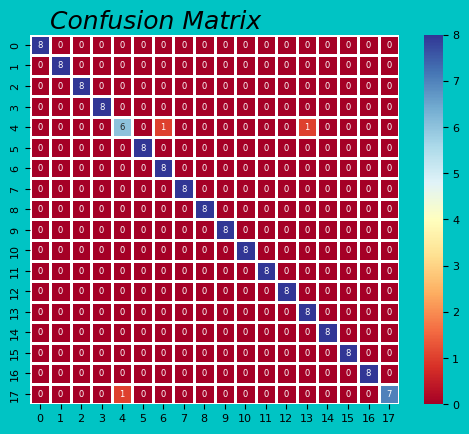

In [51]:
# confusion matrix
from sklearn.metrics import confusion_matrix
# accuracy: (tp + tn) / (p + n)
from sklearn.metrics import accuracy_score
# classification_report
from sklearn.metrics import classification_report
# kappa
from sklearn.metrics import cohen_kappa_score


true_labels = df['actual_class']
predicted_labels = df['predicted_class']

matrix = confusion_matrix(true_labels, predicted_labels)
print(matrix, '\n')

accuracy = accuracy_score(true_labels, predicted_labels)
print('Accuracy: %f' % accuracy, '\n')
print('Error rate: %f' % (1-accuracy), '\n')

# Generate classification report
report = classification_report(true_labels, predicted_labels)
print(report, '\n')

kappa = cohen_kappa_score(true_labels, predicted_labels)
print('Cohens kappa: %f' % kappa)



# Commented out IPython magic to ensure Python compatibility.
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

plt.rcParams['font.size'] = 8
bg_color = (0, 0.77, 0.77)
plt.rcParams['figure.facecolor'] = bg_color
plt.rcParams['axes.facecolor'] = bg_color

fig, ax = plt.subplots(1)

plt.text(1, -.3, "Confusion Matrix", fontsize = 18, color='Black', fontstyle='italic')

ax = sns.heatmap(matrix, annot=True, annot_kws={'size':6}, fmt="d",
                 robust=True, linewidths=.9, cmap="RdYlBu", square=True)
# vmin=0, vmax=350,
plt.savefig("Confusion_Matrix.jpeg", dpi=300, facecolor=bg_color, transparent=True)
plt.show()


# Test with unseen data

In [54]:
# Vocabulary
# vocabulary = ['bear', 'blue_whale', 'bobcat', 'cat', 'chimp', 
#               'chimpanzee', 'cow', 'dog', 'dolphin', 'giant', 
#               'giant_panda', 'gorilla', 'hippopotamus', 
#               'humpback_whale', 'killer_whale', 'leopard', 
#               'lion', 'monkey', 'mouse', 'ox', 'panda', 
#               'persian_cat', 'pig', 'polar_bear', 'rabbit', 
#               'raccoon', 'rat', 'rhinoceros', 'seal', 'sealskin', 
#               'siamese_cat', 'skunk', 'spider_monkey', 'squirrel', 
#               'tiger', 'walrus']

# synonyms_class_dct = {'chimpanzee': ['chimpanzee', 'chimp', 'monkey', 'gorilla'],
#                       'giant_panda': ['giant_panda', 'giant', 'panda', 'bear'],
#                       'seal': ['seal', 'sealskin', 'walrus'],
#                       'walrus': ['seal', 'sealskin', 'walrus'],
#                       'rat': ['rat', 'mouse']}
# print(synonyms_class_dct)


class_labels = ['bear', 'blue_whale', 'bobcat', 'cow', 'dolphin', 'gorilla', 
                'killer_whale', 'lion', 'monkey', 'mouse', 'ox', 'rabbit', 
                'rhinoceros', 'siamese_cat', 'skunk', 'squirrel', 'tiger', 'walrus']

vocabulary = ['bear', 'blue_whale', 'bobcat', 'cat', 'chimp', 
              'chimpanzee', 'cow', 'dog', 'dolphin', 'giant', 
              'giant_panda', 'gorilla', 'hippopotamus', 
              'humpback_whale', 'killer_whale', 'leopard', 
              'lion', 'monkey', 'mouse', 'ox', 'panda', 
              'persian_cat', 'pig', 'polar_bear', 'rabbit', 
              'raccoon', 'rat', 'rhinoceros', 'seal', 'sealskin', 
              'siamese_cat', 'skunk', 'spider_monkey', 'squirrel', 
              'tiger', 'walrus']

synonyms_class_dct = {'chimpanzee': ['chimpanzee', 'chimp', 'monkey', 'gorilla'],
                      'giant_panda': ['giant_panda', 'giant', 'panda', 'bear'],
                      'hippopotamus': ['hippopotamus', 'rhinoceros'],
                      'humpback_whale': ['humpback_whale', 'whale', 'blue_whale', 'killer_whale'],
                      'leopard': ['leopard', 'tiger', 'lion', 'bobcat'],
                      'persian_cat': ['persian_cat', 'siamese_cat'],
                      'pig': ['pig'],
                      'raccoon': ['raccoon', 'skunk'],
                      'seal': ['seal', 'sealskin', 'walrus'],
                      'rat': ['rat', 'mouse']}


class_numbers = {name : index for index, name in enumerate(sorted([img_path.split('\\')[-1] for img_path in glob.glob(os.path.join(VAL_DATA_PATH, '*'))]))}
print(class_numbers)

{'bear': 0, 'blue_whale': 1, 'bobcat': 2, 'cow': 3, 'dolphin': 4, 'gorilla': 5, 'killer_whale': 6, 'lion': 7, 'monkey': 8, 'mouse': 9, 'ox': 10, 'rabbit': 11, 'rhinoceros': 12, 'siamese_cat': 13, 'skunk': 14, 'squirrel': 15, 'tiger': 16, 'walrus': 17}


In [59]:
# Load models
classification_model = load_model('CNN_GLCM_GABOR_model_h5.h5')
min_max_scaler_model = load(open(min_max_scaler_file, 'rb'))
class_labels = ['bear', 'blue_whale', 'bobcat', 'cow', 'dolphin', 'gorilla', 
                'killer_whale', 'lion', 'monkey', 'mouse', 'ox', 'rabbit', 
                'rhinoceros', 'siamese_cat', 'skunk', 'squirrel', 'tiger', 'walrus']

unseen_class_labels = ['chimpanzee', 'giant_panda', 'hippopotamus', 'humpback_whale', 
                      'leopard', 'persian_cat', 'pig', 'raccoon', 'rat', 'seal']


for label in unseen_class_labels:
    folder_name = label
    folder_path = os.path.join(UNSEEN_DATA_PATH, folder_name, '*')

    image_path, image_label, pred_image_label, act_label, pred_label, similar_words = [], [], [], [], [], []

    for img_path in glob.glob(folder_path):
    # for img_path in glob.glob(r"test/*/*"):
        print(f"img_path : {img_path}")
        image_path.append(img_path)
        image_label.append(img_path.split('\\')[-2])
    #     act_label.append(class_labels.index(img_path.split('\\')[-2]))

        # Extract visual features using ResNet50
        visual_features = extract_visual_features(img_path)
    #     print(f"visual_features : {visual_features.shape} || {type(visual_features)}")

        # Compute texture features using GLCM
        GLCM_texture_feat = compute_GLCM_texture_features(img_path)
    #     GLCM_texture_features.append(GLCM_texture_feat)
    #     print(f"texture_features : {texture_features} || ")

        # Compute texture features using gabor
        gabor_texture_feat = compute_gabor_features(img_path)
    #     gabor_texture_features.append(gabor_texture_feat)
    #     print(f"texture_features : {texture_features}")

        # Concatenate visual and texture features
        l1 = visual_features[0].tolist()
        l2 = GLCM_texture_feat.tolist()
        l3 = gabor_texture_feat.tolist()
        l1.extend(l2)
        l1.extend(l3)
        combined_features = np.array(l1)
    #     print(f"combined_features : {combined_features}")

        # Normalize the features
        train_normalized_texture_features = min_max_scaler_model.transform([combined_features])
        train_normalized_texture_features_df = pd.DataFrame(train_normalized_texture_features)
    #     print(f"train_normalized_texture_features_df : {train_normalized_texture_features_df}")

    #     model.predict
        predicted_value = classification_model.predict(train_normalized_texture_features_df) # , verbos=0
        print(f"predicted_value : {np.argmax(predicted_value)} || {class_labels[np.argmax(predicted_value)]}")
        pred_image_label.append(class_labels[np.argmax(predicted_value)])
    #     pred_label.append(np.argmax(predicted_value))

        similar_words_bert = predict_with_bert(class_labels[np.argmax(predicted_value)], vocabulary) # class_labels
        print(f"similar_words_bert : {similar_words_bert}")
        similar_words.append(similar_words_bert)
    #     break


    out_df = pd.DataFrame({
        'image_path' : image_path, 
        'class_name' : image_label, 
        'pred_image_label' : pred_image_label, 
    #     'act_label' : act_label, 
    #     'pred_label' : pred_label,
        'similar_words' : similar_words
    })
    display(out_df.head())

    metadata_folder_name = 'CNN_GLCM_GABOR_BERT_metadata_with_BERT_unseen_data'
    os.makedirs(metadata_folder_name, exist_ok=True) 
    metadata_file_name = os.path.join(metadata_folder_name, folder_name + 'CNN_GLCM_GABOR_BERT_unseen_data_result.csv')
    out_df.to_csv(metadata_file_name, index = False)
    

img_path : ..\Dataset\artefact1\unseen\chimpanzee\chimpanzee_10001.jpg


C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

1/1 [==============================] - 0s 70ms/step
predicted_value : 8 || monkey
similar_words_bert : ['monkey', 'squirrel', 'rabbit', 'lion', 'tiger']
img_path : ..\Dataset\artefact1\unseen\chimpanzee\chimpanzee_10002.jpg


C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

1/1 [==============================] - 0s 27ms/step
predicted_value : 5 || gorilla
similar_words_bert : ['gorilla', 'leopard', 'tiger', 'mouse', 'panda']
img_path : ..\Dataset\artefact1\unseen\chimpanzee\chimpanzee_10003.jpg


C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

1/1 [==============================] - 0s 25ms/step
predicted_value : 17 || walrus
similar_words_bert : ['walrus', 'chimp', 'raccoon', 'bobcat', 'lion']
img_path : ..\Dataset\artefact1\unseen\chimpanzee\chimpanzee_10004.jpg


C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

1/1 [==============================] - 0s 26ms/step
predicted_value : 8 || monkey
similar_words_bert : ['monkey', 'squirrel', 'rabbit', 'lion', 'tiger']
img_path : ..\Dataset\artefact1\unseen\chimpanzee\chimpanzee_10005.jpg


C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

1/1 [==============================] - 0s 24ms/step
predicted_value : 13 || siamese_cat
similar_words_bert : ['siamese_cat', 'persian_cat', 'polar_bear', 'giant_panda', 'blue_whale']
img_path : ..\Dataset\artefact1\unseen\chimpanzee\chimpanzee_10006.jpg


C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

1/1 [==============================] - 0s 30ms/step
predicted_value : 13 || siamese_cat
similar_words_bert : ['siamese_cat', 'persian_cat', 'polar_bear', 'giant_panda', 'blue_whale']
img_path : ..\Dataset\artefact1\unseen\chimpanzee\chimpanzee_10007.jpg


C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

1/1 [==============================] - 0s 26ms/step
predicted_value : 8 || monkey
similar_words_bert : ['monkey', 'squirrel', 'rabbit', 'lion', 'tiger']
img_path : ..\Dataset\artefact1\unseen\chimpanzee\chimpanzee_10008.jpg


C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

1/1 [==============================] - 0s 27ms/step
predicted_value : 8 || monkey
similar_words_bert : ['monkey', 'squirrel', 'rabbit', 'lion', 'tiger']
img_path : ..\Dataset\artefact1\unseen\chimpanzee\chimpanzee_10009.jpg


C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

1/1 [==============================] - 0s 40ms/step
predicted_value : 10 || ox
similar_words_bert : ['ox', 'pig', 'mouse', 'cow', 'rabbit']
img_path : ..\Dataset\artefact1\unseen\chimpanzee\chimpanzee_10010.jpg


C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

1/1 [==============================] - 0s 27ms/step
predicted_value : 8 || monkey
similar_words_bert : ['monkey', 'squirrel', 'rabbit', 'lion', 'tiger']


image_path  class_name  \
0  ..\Dataset\artefact1\unseen\chimpanzee\chimpan...  chimpanzee   
1  ..\Dataset\artefact1\unseen\chimpanzee\chimpan...  chimpanzee   
2  ..\Dataset\artefact1\unseen\chimpanzee\chimpan...  chimpanzee   
3  ..\Dataset\artefact1\unseen\chimpanzee\chimpan...  chimpanzee   
4  ..\Dataset\artefact1\unseen\chimpanzee\chimpan...  chimpanzee   

  pred_image_label                                      similar_words  
0           monkey            [monkey, squirrel, rabbit, lion, tiger]  
1          gorilla            [gorilla, leopard, tiger, mouse, panda]  
2           walrus             [walrus, chimp, raccoon, bobcat, lion]  
3           monkey            [monkey, squirrel, rabbit, lion, tiger]  
4      siamese_cat  [siamese_cat, persian_cat, polar_bear, giant_p...

img_path : ..\Dataset\artefact1\unseen\giant_panda\giant+panda_10001.jpg


C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

1/1 [==============================] - 0s 29ms/step
predicted_value : 8 || monkey
similar_words_bert : ['monkey', 'squirrel', 'rabbit', 'lion', 'tiger']
img_path : ..\Dataset\artefact1\unseen\giant_panda\giant+panda_10002.jpg


C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

1/1 [==============================] - 0s 37ms/step
predicted_value : 11 || rabbit
similar_words_bert : ['rabbit', 'squirrel', 'monkey', 'pig', 'tiger']
img_path : ..\Dataset\artefact1\unseen\giant_panda\giant+panda_10003.jpg


C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

1/1 [==============================] - 0s 36ms/step
predicted_value : 0 || bear
similar_words_bert : ['bear', 'rabbit', 'giant', 'tiger', 'pig']
img_path : ..\Dataset\artefact1\unseen\giant_panda\giant+panda_10004.jpg


C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

1/1 [==============================] - 0s 33ms/step
predicted_value : 0 || bear
similar_words_bert : ['bear', 'rabbit', 'giant', 'tiger', 'pig']
img_path : ..\Dataset\artefact1\unseen\giant_panda\giant+panda_10005.jpg


C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

1/1 [==============================] - 0s 25ms/step
predicted_value : 11 || rabbit
similar_words_bert : ['rabbit', 'squirrel', 'monkey', 'pig', 'tiger']
img_path : ..\Dataset\artefact1\unseen\giant_panda\giant+panda_10006.jpg


C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

1/1 [==============================] - 0s 26ms/step
predicted_value : 8 || monkey
similar_words_bert : ['monkey', 'squirrel', 'rabbit', 'lion', 'tiger']
img_path : ..\Dataset\artefact1\unseen\giant_panda\giant+panda_10007.jpg


C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

1/1 [==============================] - 0s 34ms/step
predicted_value : 0 || bear
similar_words_bert : ['bear', 'rabbit', 'giant', 'tiger', 'pig']
img_path : ..\Dataset\artefact1\unseen\giant_panda\giant+panda_10008.jpg


C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

1/1 [==============================] - 0s 50ms/step
predicted_value : 8 || monkey
similar_words_bert : ['monkey', 'squirrel', 'rabbit', 'lion', 'tiger']
img_path : ..\Dataset\artefact1\unseen\giant_panda\giant+panda_10009.jpg


C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

1/1 [==============================] - 0s 26ms/step
predicted_value : 8 || monkey
similar_words_bert : ['monkey', 'squirrel', 'rabbit', 'lion', 'tiger']
img_path : ..\Dataset\artefact1\unseen\giant_panda\giant+panda_10010.jpg


C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

1/1 [==============================] - 0s 30ms/step
predicted_value : 17 || walrus
similar_words_bert : ['walrus', 'chimp', 'raccoon', 'bobcat', 'lion']


image_path   class_name  \
0  ..\Dataset\artefact1\unseen\giant_panda\giant+...  giant_panda   
1  ..\Dataset\artefact1\unseen\giant_panda\giant+...  giant_panda   
2  ..\Dataset\artefact1\unseen\giant_panda\giant+...  giant_panda   
3  ..\Dataset\artefact1\unseen\giant_panda\giant+...  giant_panda   
4  ..\Dataset\artefact1\unseen\giant_panda\giant+...  giant_panda   

  pred_image_label                            similar_words  
0           monkey  [monkey, squirrel, rabbit, lion, tiger]  
1           rabbit   [rabbit, squirrel, monkey, pig, tiger]  
2             bear        [bear, rabbit, giant, tiger, pig]  
3             bear        [bear, rabbit, giant, tiger, pig]  
4           rabbit   [rabbit, squirrel, monkey, pig, tiger]

img_path : ..\Dataset\artefact1\unseen\hippopotamus\hippopotamus_10001.jpg


C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

1/1 [==============================] - 0s 26ms/step
predicted_value : 10 || ox
similar_words_bert : ['ox', 'pig', 'mouse', 'cow', 'rabbit']
img_path : ..\Dataset\artefact1\unseen\hippopotamus\hippopotamus_10002.jpg


C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

1/1 [==============================] - 0s 26ms/step
predicted_value : 13 || siamese_cat
similar_words_bert : ['siamese_cat', 'persian_cat', 'polar_bear', 'giant_panda', 'blue_whale']
img_path : ..\Dataset\artefact1\unseen\hippopotamus\hippopotamus_10003.jpg


C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

1/1 [==============================] - 0s 26ms/step
predicted_value : 12 || rhinoceros
similar_words_bert : ['rhinoceros', 'walrus', 'bobcat', 'raccoon', 'chimpanzee']
img_path : ..\Dataset\artefact1\unseen\hippopotamus\hippopotamus_10004.jpg


C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

1/1 [==============================] - 0s 26ms/step
predicted_value : 3 || cow
similar_words_bert : ['cow', 'pig', 'rabbit', 'squirrel', 'bear']
img_path : ..\Dataset\artefact1\unseen\hippopotamus\hippopotamus_10005.jpg


C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

1/1 [==============================] - 0s 26ms/step
predicted_value : 10 || ox
similar_words_bert : ['ox', 'pig', 'mouse', 'cow', 'rabbit']
img_path : ..\Dataset\artefact1\unseen\hippopotamus\hippopotamus_10006.jpg


C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remove

1/1 [==============================] - 0s 66ms/step
predicted_value : 12 || rhinoceros
similar_words_bert : ['rhinoceros', 'walrus', 'bobcat', 'raccoon', 'chimpanzee']
img_path : ..\Dataset\artefact1\unseen\hippopotamus\hippopotamus_10007.jpg


C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

1/1 [==============================] - 0s 28ms/step
predicted_value : 17 || walrus
similar_words_bert : ['walrus', 'chimp', 'raccoon', 'bobcat', 'lion']
img_path : ..\Dataset\artefact1\unseen\hippopotamus\hippopotamus_10008.jpg


C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

1/1 [==============================] - 0s 26ms/step
predicted_value : 1 || blue_whale
similar_words_bert : ['blue_whale', 'killer_whale', 'polar_bear', 'giant_panda', 'humpback_whale']
img_path : ..\Dataset\artefact1\unseen\hippopotamus\hippopotamus_10009.jpg


C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

1/1 [==============================] - 0s 28ms/step
predicted_value : 6 || killer_whale
similar_words_bert : ['killer_whale', 'blue_whale', 'polar_bear', 'giant_panda', 'humpback_whale']
img_path : ..\Dataset\artefact1\unseen\hippopotamus\hippopotamus_10010.jpg


C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

1/1 [==============================] - 0s 25ms/step
predicted_value : 12 || rhinoceros
similar_words_bert : ['rhinoceros', 'walrus', 'bobcat', 'raccoon', 'chimpanzee']


image_path    class_name  \
0  ..\Dataset\artefact1\unseen\hippopotamus\hippo...  hippopotamus   
1  ..\Dataset\artefact1\unseen\hippopotamus\hippo...  hippopotamus   
2  ..\Dataset\artefact1\unseen\hippopotamus\hippo...  hippopotamus   
3  ..\Dataset\artefact1\unseen\hippopotamus\hippo...  hippopotamus   
4  ..\Dataset\artefact1\unseen\hippopotamus\hippo...  hippopotamus   

  pred_image_label                                      similar_words  
0               ox                      [ox, pig, mouse, cow, rabbit]  
1      siamese_cat  [siamese_cat, persian_cat, polar_bear, giant_p...  
2       rhinoceros  [rhinoceros, walrus, bobcat, raccoon, chimpanzee]  
3              cow                 [cow, pig, rabbit, squirrel, bear]  
4               ox                      [ox, pig, mouse, cow, rabbit]

img_path : ..\Dataset\artefact1\unseen\humpback_whale\humpback+whale_10001.jpg


C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

1/1 [==============================] - 0s 51ms/step
predicted_value : 4 || dolphin
similar_words_bert : ['dolphin', 'lion', 'monkey', 'squirrel', 'dog']
img_path : ..\Dataset\artefact1\unseen\humpback_whale\humpback+whale_10002.jpg


C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

1/1 [==============================] - 0s 28ms/step
predicted_value : 1 || blue_whale
similar_words_bert : ['blue_whale', 'killer_whale', 'polar_bear', 'giant_panda', 'humpback_whale']
img_path : ..\Dataset\artefact1\unseen\humpback_whale\humpback+whale_10003.jpg


C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

1/1 [==============================] - 0s 35ms/step
predicted_value : 6 || killer_whale
similar_words_bert : ['killer_whale', 'blue_whale', 'polar_bear', 'giant_panda', 'humpback_whale']
img_path : ..\Dataset\artefact1\unseen\humpback_whale\humpback+whale_10004.jpg


C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

1/1 [==============================] - 0s 61ms/step
predicted_value : 1 || blue_whale
similar_words_bert : ['blue_whale', 'killer_whale', 'polar_bear', 'giant_panda', 'humpback_whale']
img_path : ..\Dataset\artefact1\unseen\humpback_whale\humpback+whale_10005.jpg


C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

1/1 [==============================] - 0s 51ms/step
predicted_value : 6 || killer_whale
similar_words_bert : ['killer_whale', 'blue_whale', 'polar_bear', 'giant_panda', 'humpback_whale']
img_path : ..\Dataset\artefact1\unseen\humpback_whale\humpback+whale_10006.jpg


C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

1/1 [==============================] - 0s 69ms/step
predicted_value : 1 || blue_whale
similar_words_bert : ['blue_whale', 'killer_whale', 'polar_bear', 'giant_panda', 'humpback_whale']
img_path : ..\Dataset\artefact1\unseen\humpback_whale\humpback+whale_10007.jpg


C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

1/1 [==============================] - 0s 28ms/step
predicted_value : 6 || killer_whale
similar_words_bert : ['killer_whale', 'blue_whale', 'polar_bear', 'giant_panda', 'humpback_whale']
img_path : ..\Dataset\artefact1\unseen\humpback_whale\humpback+whale_10008.jpg


C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

1/1 [==============================] - 0s 57ms/step
predicted_value : 6 || killer_whale
similar_words_bert : ['killer_whale', 'blue_whale', 'polar_bear', 'giant_panda', 'humpback_whale']
img_path : ..\Dataset\artefact1\unseen\humpback_whale\humpback+whale_10009.jpg


C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

1/1 [==============================] - 0s 29ms/step
predicted_value : 1 || blue_whale
similar_words_bert : ['blue_whale', 'killer_whale', 'polar_bear', 'giant_panda', 'humpback_whale']
img_path : ..\Dataset\artefact1\unseen\humpback_whale\humpback+whale_10010.jpg


C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

1/1 [==============================] - 0s 29ms/step
predicted_value : 1 || blue_whale
similar_words_bert : ['blue_whale', 'killer_whale', 'polar_bear', 'giant_panda', 'humpback_whale']


image_path      class_name  \
0  ..\Dataset\artefact1\unseen\humpback_whale\hum...  humpback_whale   
1  ..\Dataset\artefact1\unseen\humpback_whale\hum...  humpback_whale   
2  ..\Dataset\artefact1\unseen\humpback_whale\hum...  humpback_whale   
3  ..\Dataset\artefact1\unseen\humpback_whale\hum...  humpback_whale   
4  ..\Dataset\artefact1\unseen\humpback_whale\hum...  humpback_whale   

  pred_image_label                                      similar_words  
0          dolphin             [dolphin, lion, monkey, squirrel, dog]  
1       blue_whale  [blue_whale, killer_whale, polar_bear, giant_p...  
2     killer_whale  [killer_whale, blue_whale, polar_bear, giant_p...  
3       blue_whale  [blue_whale, killer_whale, polar_bear, giant_p...  
4     killer_whale  [killer_whale, blue_whale, polar_bear, giant_p...

img_path : ..\Dataset\artefact1\unseen\leopard\leopard_10001.jpg


C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

1/1 [==============================] - 0s 42ms/step
predicted_value : 2 || bobcat
similar_words_bert : ['bobcat', 'walrus', 'raccoon', 'rhinoceros', 'chimp']
img_path : ..\Dataset\artefact1\unseen\leopard\leopard_10002.jpg


C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

1/1 [==============================] - 0s 42ms/step
predicted_value : 2 || bobcat
similar_words_bert : ['bobcat', 'walrus', 'raccoon', 'rhinoceros', 'chimp']
img_path : ..\Dataset\artefact1\unseen\leopard\leopard_10003.jpg


C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

1/1 [==============================] - 0s 37ms/step
predicted_value : 16 || tiger
similar_words_bert : ['tiger', 'rabbit', 'monkey', 'lion', 'bear']
img_path : ..\Dataset\artefact1\unseen\leopard\leopard_10004.jpg


C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

1/1 [==============================] - 0s 26ms/step
predicted_value : 2 || bobcat
similar_words_bert : ['bobcat', 'walrus', 'raccoon', 'rhinoceros', 'chimp']
img_path : ..\Dataset\artefact1\unseen\leopard\leopard_10005.jpg


C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

1/1 [==============================] - 0s 29ms/step
predicted_value : 2 || bobcat
similar_words_bert : ['bobcat', 'walrus', 'raccoon', 'rhinoceros', 'chimp']
img_path : ..\Dataset\artefact1\unseen\leopard\leopard_10006.jpg


C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

1/1 [==============================] - 0s 38ms/step
predicted_value : 2 || bobcat
similar_words_bert : ['bobcat', 'walrus', 'raccoon', 'rhinoceros', 'chimp']
img_path : ..\Dataset\artefact1\unseen\leopard\leopard_10007.jpg


C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

1/1 [==============================] - 0s 27ms/step
predicted_value : 2 || bobcat
similar_words_bert : ['bobcat', 'walrus', 'raccoon', 'rhinoceros', 'chimp']
img_path : ..\Dataset\artefact1\unseen\leopard\leopard_10008.jpg


C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

1/1 [==============================] - 0s 27ms/step
predicted_value : 7 || lion
similar_words_bert : ['lion', 'squirrel', 'giant', 'monkey', 'rabbit']
img_path : ..\Dataset\artefact1\unseen\leopard\leopard_10009.jpg


C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

1/1 [==============================] - 0s 31ms/step
predicted_value : 16 || tiger
similar_words_bert : ['tiger', 'rabbit', 'monkey', 'lion', 'bear']
img_path : ..\Dataset\artefact1\unseen\leopard\leopard_10010.jpg


C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

1/1 [==============================] - 0s 33ms/step
predicted_value : 16 || tiger
similar_words_bert : ['tiger', 'rabbit', 'monkey', 'lion', 'bear']


image_path class_name  \
0  ..\Dataset\artefact1\unseen\leopard\leopard_10...    leopard   
1  ..\Dataset\artefact1\unseen\leopard\leopard_10...    leopard   
2  ..\Dataset\artefact1\unseen\leopard\leopard_10...    leopard   
3  ..\Dataset\artefact1\unseen\leopard\leopard_10...    leopard   
4  ..\Dataset\artefact1\unseen\leopard\leopard_10...    leopard   

  pred_image_label                                 similar_words  
0           bobcat  [bobcat, walrus, raccoon, rhinoceros, chimp]  
1           bobcat  [bobcat, walrus, raccoon, rhinoceros, chimp]  
2            tiger           [tiger, rabbit, monkey, lion, bear]  
3           bobcat  [bobcat, walrus, raccoon, rhinoceros, chimp]  
4           bobcat  [bobcat, walrus, raccoon, rhinoceros, chimp]

img_path : ..\Dataset\artefact1\unseen\persian_cat\persian+cat_10001.jpg


C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

1/1 [==============================] - 0s 26ms/step
predicted_value : 13 || siamese_cat
similar_words_bert : ['siamese_cat', 'persian_cat', 'polar_bear', 'giant_panda', 'blue_whale']
img_path : ..\Dataset\artefact1\unseen\persian_cat\persian+cat_10002.jpg


C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

1/1 [==============================] - 0s 39ms/step
predicted_value : 13 || siamese_cat
similar_words_bert : ['siamese_cat', 'persian_cat', 'polar_bear', 'giant_panda', 'blue_whale']
img_path : ..\Dataset\artefact1\unseen\persian_cat\persian+cat_10003.jpg


C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

1/1 [==============================] - 0s 24ms/step
predicted_value : 13 || siamese_cat
similar_words_bert : ['siamese_cat', 'persian_cat', 'polar_bear', 'giant_panda', 'blue_whale']
img_path : ..\Dataset\artefact1\unseen\persian_cat\persian+cat_10004.jpg


C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

1/1 [==============================] - 0s 26ms/step
predicted_value : 13 || siamese_cat
similar_words_bert : ['siamese_cat', 'persian_cat', 'polar_bear', 'giant_panda', 'blue_whale']
img_path : ..\Dataset\artefact1\unseen\persian_cat\persian+cat_10005.jpg


C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

1/1 [==============================] - 0s 26ms/step
predicted_value : 13 || siamese_cat
similar_words_bert : ['siamese_cat', 'persian_cat', 'polar_bear', 'giant_panda', 'blue_whale']
img_path : ..\Dataset\artefact1\unseen\persian_cat\persian+cat_10006.jpg


C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

1/1 [==============================] - 0s 30ms/step
predicted_value : 2 || bobcat
similar_words_bert : ['bobcat', 'walrus', 'raccoon', 'rhinoceros', 'chimp']
img_path : ..\Dataset\artefact1\unseen\persian_cat\persian+cat_10007.jpg


C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

1/1 [==============================] - 0s 26ms/step
predicted_value : 13 || siamese_cat
similar_words_bert : ['siamese_cat', 'persian_cat', 'polar_bear', 'giant_panda', 'blue_whale']
img_path : ..\Dataset\artefact1\unseen\persian_cat\persian+cat_10008.jpg


C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

1/1 [==============================] - 0s 25ms/step
predicted_value : 13 || siamese_cat
similar_words_bert : ['siamese_cat', 'persian_cat', 'polar_bear', 'giant_panda', 'blue_whale']
img_path : ..\Dataset\artefact1\unseen\persian_cat\persian+cat_10009.jpg


C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

1/1 [==============================] - 0s 45ms/step
predicted_value : 13 || siamese_cat
similar_words_bert : ['siamese_cat', 'persian_cat', 'polar_bear', 'giant_panda', 'blue_whale']
img_path : ..\Dataset\artefact1\unseen\persian_cat\persian+cat_10010.jpg


C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

1/1 [==============================] - 0s 29ms/step
predicted_value : 13 || siamese_cat
similar_words_bert : ['siamese_cat', 'persian_cat', 'polar_bear', 'giant_panda', 'blue_whale']


image_path   class_name  \
0  ..\Dataset\artefact1\unseen\persian_cat\persia...  persian_cat   
1  ..\Dataset\artefact1\unseen\persian_cat\persia...  persian_cat   
2  ..\Dataset\artefact1\unseen\persian_cat\persia...  persian_cat   
3  ..\Dataset\artefact1\unseen\persian_cat\persia...  persian_cat   
4  ..\Dataset\artefact1\unseen\persian_cat\persia...  persian_cat   

  pred_image_label                                      similar_words  
0      siamese_cat  [siamese_cat, persian_cat, polar_bear, giant_p...  
1      siamese_cat  [siamese_cat, persian_cat, polar_bear, giant_p...  
2      siamese_cat  [siamese_cat, persian_cat, polar_bear, giant_p...  
3      siamese_cat  [siamese_cat, persian_cat, polar_bear, giant_p...  
4      siamese_cat  [siamese_cat, persian_cat, polar_bear, giant_p...

img_path : ..\Dataset\artefact1\unseen\pig\pig_10001.jpg


C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

1/1 [==============================] - 0s 30ms/step
predicted_value : 8 || monkey
similar_words_bert : ['monkey', 'squirrel', 'rabbit', 'lion', 'tiger']
img_path : ..\Dataset\artefact1\unseen\pig\pig_10002.jpg


C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

1/1 [==============================] - 0s 31ms/step
predicted_value : 9 || mouse
similar_words_bert : ['mouse', 'pig', 'rabbit', 'squirrel', 'bear']
img_path : ..\Dataset\artefact1\unseen\pig\pig_10003.jpg


C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

1/1 [==============================] - 0s 26ms/step
predicted_value : 11 || rabbit
similar_words_bert : ['rabbit', 'squirrel', 'monkey', 'pig', 'tiger']
img_path : ..\Dataset\artefact1\unseen\pig\pig_10004.jpg


C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

1/1 [==============================] - 0s 25ms/step
predicted_value : 17 || walrus
similar_words_bert : ['walrus', 'chimp', 'raccoon', 'bobcat', 'lion']
img_path : ..\Dataset\artefact1\unseen\pig\pig_10005.jpg


C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

1/1 [==============================] - 0s 29ms/step
predicted_value : 7 || lion
similar_words_bert : ['lion', 'squirrel', 'giant', 'monkey', 'rabbit']
img_path : ..\Dataset\artefact1\unseen\pig\pig_10006.jpg


C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

1/1 [==============================] - 0s 26ms/step
predicted_value : 3 || cow
similar_words_bert : ['cow', 'pig', 'rabbit', 'squirrel', 'bear']
img_path : ..\Dataset\artefact1\unseen\pig\pig_10007.jpg


C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

1/1 [==============================] - 0s 28ms/step
predicted_value : 3 || cow
similar_words_bert : ['cow', 'pig', 'rabbit', 'squirrel', 'bear']
img_path : ..\Dataset\artefact1\unseen\pig\pig_10008.jpg


C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

1/1 [==============================] - 0s 28ms/step
predicted_value : 17 || walrus
similar_words_bert : ['walrus', 'chimp', 'raccoon', 'bobcat', 'lion']
img_path : ..\Dataset\artefact1\unseen\pig\pig_10009.jpg


C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

1/1 [==============================] - 0s 29ms/step
predicted_value : 17 || walrus
similar_words_bert : ['walrus', 'chimp', 'raccoon', 'bobcat', 'lion']
img_path : ..\Dataset\artefact1\unseen\pig\pig_10010.jpg


C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

1/1 [==============================] - 0s 31ms/step
predicted_value : 3 || cow
similar_words_bert : ['cow', 'pig', 'rabbit', 'squirrel', 'bear']


image_path class_name pred_image_label  \
0  ..\Dataset\artefact1\unseen\pig\pig_10001.jpg        pig           monkey   
1  ..\Dataset\artefact1\unseen\pig\pig_10002.jpg        pig            mouse   
2  ..\Dataset\artefact1\unseen\pig\pig_10003.jpg        pig           rabbit   
3  ..\Dataset\artefact1\unseen\pig\pig_10004.jpg        pig           walrus   
4  ..\Dataset\artefact1\unseen\pig\pig_10005.jpg        pig             lion   

                             similar_words  
0  [monkey, squirrel, rabbit, lion, tiger]  
1     [mouse, pig, rabbit, squirrel, bear]  
2   [rabbit, squirrel, monkey, pig, tiger]  
3   [walrus, chimp, raccoon, bobcat, lion]  
4  [lion, squirrel, giant, monkey, rabbit]

img_path : ..\Dataset\artefact1\unseen\raccoon\raccoon_10001.jpg


C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

1/1 [==============================] - 0s 28ms/step
predicted_value : 15 || squirrel
similar_words_bert : ['squirrel', 'monkey', 'rabbit', 'lion', 'pig']
img_path : ..\Dataset\artefact1\unseen\raccoon\raccoon_10002.jpg


C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

1/1 [==============================] - 0s 27ms/step
predicted_value : 14 || skunk
similar_words_bert : ['skunk', 'dog', 'monkey', 'walrus', 'squirrel']
img_path : ..\Dataset\artefact1\unseen\raccoon\raccoon_10003.jpg


C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

1/1 [==============================] - 0s 26ms/step
predicted_value : 15 || squirrel
similar_words_bert : ['squirrel', 'monkey', 'rabbit', 'lion', 'pig']
img_path : ..\Dataset\artefact1\unseen\raccoon\raccoon_10004.jpg


C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

1/1 [==============================] - 0s 31ms/step
predicted_value : 11 || rabbit
similar_words_bert : ['rabbit', 'squirrel', 'monkey', 'pig', 'tiger']
img_path : ..\Dataset\artefact1\unseen\raccoon\raccoon_10005.jpg


C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

1/1 [==============================] - 0s 25ms/step
predicted_value : 9 || mouse
similar_words_bert : ['mouse', 'pig', 'rabbit', 'squirrel', 'bear']
img_path : ..\Dataset\artefact1\unseen\raccoon\raccoon_10006.jpg


C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

1/1 [==============================] - 0s 29ms/step
predicted_value : 15 || squirrel
similar_words_bert : ['squirrel', 'monkey', 'rabbit', 'lion', 'pig']
img_path : ..\Dataset\artefact1\unseen\raccoon\raccoon_10007.jpg


C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

1/1 [==============================] - 0s 62ms/step
predicted_value : 15 || squirrel
similar_words_bert : ['squirrel', 'monkey', 'rabbit', 'lion', 'pig']
img_path : ..\Dataset\artefact1\unseen\raccoon\raccoon_10008.jpg


C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

1/1 [==============================] - 0s 43ms/step
predicted_value : 3 || cow
similar_words_bert : ['cow', 'pig', 'rabbit', 'squirrel', 'bear']
img_path : ..\Dataset\artefact1\unseen\raccoon\raccoon_10009.jpg


C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

1/1 [==============================] - 0s 187ms/step
predicted_value : 13 || siamese_cat
similar_words_bert : ['siamese_cat', 'persian_cat', 'polar_bear', 'giant_panda', 'blue_whale']
img_path : ..\Dataset\artefact1\unseen\raccoon\raccoon_10010.jpg


C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

1/1 [==============================] - 0s 33ms/step
predicted_value : 9 || mouse
similar_words_bert : ['mouse', 'pig', 'rabbit', 'squirrel', 'bear']


image_path class_name  \
0  ..\Dataset\artefact1\unseen\raccoon\raccoon_10...    raccoon   
1  ..\Dataset\artefact1\unseen\raccoon\raccoon_10...    raccoon   
2  ..\Dataset\artefact1\unseen\raccoon\raccoon_10...    raccoon   
3  ..\Dataset\artefact1\unseen\raccoon\raccoon_10...    raccoon   
4  ..\Dataset\artefact1\unseen\raccoon\raccoon_10...    raccoon   

  pred_image_label                           similar_words  
0         squirrel   [squirrel, monkey, rabbit, lion, pig]  
1            skunk  [skunk, dog, monkey, walrus, squirrel]  
2         squirrel   [squirrel, monkey, rabbit, lion, pig]  
3           rabbit  [rabbit, squirrel, monkey, pig, tiger]  
4            mouse    [mouse, pig, rabbit, squirrel, bear]

img_path : ..\Dataset\artefact1\unseen\rat\rat_10001.jpg


C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

1/1 [==============================] - 0s 26ms/step
predicted_value : 9 || mouse
similar_words_bert : ['mouse', 'pig', 'rabbit', 'squirrel', 'bear']
img_path : ..\Dataset\artefact1\unseen\rat\rat_10002.jpg


C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

1/1 [==============================] - 0s 26ms/step
predicted_value : 13 || siamese_cat
similar_words_bert : ['siamese_cat', 'persian_cat', 'polar_bear', 'giant_panda', 'blue_whale']
img_path : ..\Dataset\artefact1\unseen\rat\rat_10003.jpg


C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

1/1 [==============================] - 0s 32ms/step
predicted_value : 9 || mouse
similar_words_bert : ['mouse', 'pig', 'rabbit', 'squirrel', 'bear']
img_path : ..\Dataset\artefact1\unseen\rat\rat_10004.jpg


C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

1/1 [==============================] - 0s 28ms/step
predicted_value : 13 || siamese_cat
similar_words_bert : ['siamese_cat', 'persian_cat', 'polar_bear', 'giant_panda', 'blue_whale']
img_path : ..\Dataset\artefact1\unseen\rat\rat_10005.jpg


C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

1/1 [==============================] - 0s 54ms/step
predicted_value : 13 || siamese_cat
similar_words_bert : ['siamese_cat', 'persian_cat', 'polar_bear', 'giant_panda', 'blue_whale']
img_path : ..\Dataset\artefact1\unseen\rat\rat_10006.jpg


C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

1/1 [==============================] - 0s 31ms/step
predicted_value : 13 || siamese_cat
similar_words_bert : ['siamese_cat', 'persian_cat', 'polar_bear', 'giant_panda', 'blue_whale']
img_path : ..\Dataset\artefact1\unseen\rat\rat_10007.jpg


C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

1/1 [==============================] - 0s 41ms/step
predicted_value : 13 || siamese_cat
similar_words_bert : ['siamese_cat', 'persian_cat', 'polar_bear', 'giant_panda', 'blue_whale']
img_path : ..\Dataset\artefact1\unseen\rat\rat_10008.jpg


C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

1/1 [==============================] - 0s 52ms/step
predicted_value : 13 || siamese_cat
similar_words_bert : ['siamese_cat', 'persian_cat', 'polar_bear', 'giant_panda', 'blue_whale']
img_path : ..\Dataset\artefact1\unseen\rat\rat_10009.jpg


C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

1/1 [==============================] - 0s 35ms/step
predicted_value : 13 || siamese_cat
similar_words_bert : ['siamese_cat', 'persian_cat', 'polar_bear', 'giant_panda', 'blue_whale']
img_path : ..\Dataset\artefact1\unseen\rat\rat_10010.jpg


C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

1/1 [==============================] - 0s 28ms/step
predicted_value : 8 || monkey
similar_words_bert : ['monkey', 'squirrel', 'rabbit', 'lion', 'tiger']


image_path class_name pred_image_label  \
0  ..\Dataset\artefact1\unseen\rat\rat_10001.jpg        rat            mouse   
1  ..\Dataset\artefact1\unseen\rat\rat_10002.jpg        rat      siamese_cat   
2  ..\Dataset\artefact1\unseen\rat\rat_10003.jpg        rat            mouse   
3  ..\Dataset\artefact1\unseen\rat\rat_10004.jpg        rat      siamese_cat   
4  ..\Dataset\artefact1\unseen\rat\rat_10005.jpg        rat      siamese_cat   

                                       similar_words  
0               [mouse, pig, rabbit, squirrel, bear]  
1  [siamese_cat, persian_cat, polar_bear, giant_p...  
2               [mouse, pig, rabbit, squirrel, bear]  
3  [siamese_cat, persian_cat, polar_bear, giant_p...  
4  [siamese_cat, persian_cat, polar_bear, giant_p...

img_path : ..\Dataset\artefact1\unseen\seal\seal_10001.jpg


C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

1/1 [==============================] - 0s 25ms/step
predicted_value : 14 || skunk
similar_words_bert : ['skunk', 'dog', 'monkey', 'walrus', 'squirrel']
img_path : ..\Dataset\artefact1\unseen\seal\seal_10002.jpg


C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

1/1 [==============================] - 0s 28ms/step
predicted_value : 17 || walrus
similar_words_bert : ['walrus', 'chimp', 'raccoon', 'bobcat', 'lion']
img_path : ..\Dataset\artefact1\unseen\seal\seal_10003.jpg


C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

1/1 [==============================] - 0s 25ms/step
predicted_value : 17 || walrus
similar_words_bert : ['walrus', 'chimp', 'raccoon', 'bobcat', 'lion']
img_path : ..\Dataset\artefact1\unseen\seal\seal_10004.jpg


C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

1/1 [==============================] - 0s 33ms/step
predicted_value : 6 || killer_whale
similar_words_bert : ['killer_whale', 'blue_whale', 'polar_bear', 'giant_panda', 'humpback_whale']
img_path : ..\Dataset\artefact1\unseen\seal\seal_10005.jpg


C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

1/1 [==============================] - 0s 24ms/step
predicted_value : 13 || siamese_cat
similar_words_bert : ['siamese_cat', 'persian_cat', 'polar_bear', 'giant_panda', 'blue_whale']
img_path : ..\Dataset\artefact1\unseen\seal\seal_10006.jpg


C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

1/1 [==============================] - 0s 33ms/step
predicted_value : 12 || rhinoceros
similar_words_bert : ['rhinoceros', 'walrus', 'bobcat', 'raccoon', 'chimpanzee']
img_path : ..\Dataset\artefact1\unseen\seal\seal_10007.jpg


C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')


1/1 [==============================] - 0s 31ms/step
predicted_value : 17 || walrus
similar_words_bert : ['walrus', 'chimp', 'raccoon', 'bobcat', 'lion']
img_path : ..\Dataset\artefact1\unseen\seal\seal_10008.jpg


C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

1/1 [==============================] - 0s 35ms/step
predicted_value : 17 || walrus
similar_words_bert : ['walrus', 'chimp', 'raccoon', 'bobcat', 'lion']
img_path : ..\Dataset\artefact1\unseen\seal\seal_10009.jpg


C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

1/1 [==============================] - 0s 59ms/step
predicted_value : 17 || walrus
similar_words_bert : ['walrus', 'chimp', 'raccoon', 'bobcat', 'lion']
img_path : ..\Dataset\artefact1\unseen\seal\seal_10010.jpg


C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

1/1 [==============================] - 0s 40ms/step
predicted_value : 17 || walrus
similar_words_bert : ['walrus', 'chimp', 'raccoon', 'bobcat', 'lion']


image_path class_name  \
0  ..\Dataset\artefact1\unseen\seal\seal_10001.jpg       seal   
1  ..\Dataset\artefact1\unseen\seal\seal_10002.jpg       seal   
2  ..\Dataset\artefact1\unseen\seal\seal_10003.jpg       seal   
3  ..\Dataset\artefact1\unseen\seal\seal_10004.jpg       seal   
4  ..\Dataset\artefact1\unseen\seal\seal_10005.jpg       seal   

  pred_image_label                                      similar_words  
0            skunk             [skunk, dog, monkey, walrus, squirrel]  
1           walrus             [walrus, chimp, raccoon, bobcat, lion]  
2           walrus             [walrus, chimp, raccoon, bobcat, lion]  
3     killer_whale  [killer_whale, blue_whale, polar_bear, giant_p...  
4      siamese_cat  [siamese_cat, persian_cat, polar_bear, giant_p...

In [60]:
'''
Note : Run only after compliting all classes
'''
metadata_file_name = os.path.join(metadata_folder_name, '*')
df_list = [pd.read_csv(df_path) for df_path in glob.glob(metadata_file_name)]

out_df = pd.concat(df_list).reset_index(drop=True)

# out_df['similar_words'] = out_df['similar_words'].apply(ast.literal_eval)

out_df

image_path  class_name  \
0   ..\Dataset\artefact1\unseen\chimpanzee\chimpan...  chimpanzee   
1   ..\Dataset\artefact1\unseen\chimpanzee\chimpan...  chimpanzee   
2   ..\Dataset\artefact1\unseen\chimpanzee\chimpan...  chimpanzee   
3   ..\Dataset\artefact1\unseen\chimpanzee\chimpan...  chimpanzee   
4   ..\Dataset\artefact1\unseen\chimpanzee\chimpan...  chimpanzee   
..                                                ...         ...   
95    ..\Dataset\artefact1\unseen\seal\seal_10006.jpg        seal   
96    ..\Dataset\artefact1\unseen\seal\seal_10007.jpg        seal   
97    ..\Dataset\artefact1\unseen\seal\seal_10008.jpg        seal   
98    ..\Dataset\artefact1\unseen\seal\seal_10009.jpg        seal   
99    ..\Dataset\artefact1\unseen\seal\seal_10010.jpg        seal   

   pred_image_label                                      similar_words  
0            monkey  ['monkey', 'squirrel', 'rabbit', 'lion', 'tiger']  
1           gorilla  ['gorilla', 'leopard', 'tiger', 'mouse', 'panda']  
2            walrus   ['walrus', 'chimp', 'raccoon', 'bobcat', 'lion']  
3            monkey  ['monkey', 'squirrel', 'rabbit', 'lion', 'tiger']  
4       siamese_cat  ['siamese_cat', 'persian_cat', 'polar_bear', '...  
..              ...                                                ...  
95       rhinoceros  ['rhinoceros', 'walrus', 'bobcat', 'raccoon', ...  
96           walrus   ['walrus', 'chimp', 'raccoon', 'bobcat', 'lion']  
97           walrus   ['walrus', 'chimp', 'raccoon', 'bobcat', 'lion']  
98           walrus   ['walrus', 'chimp', 'raccoon', 'bobcat', 'lion']  
99           walrus   ['walrus', 'chimp', 'raccoon', 'bobcat', 'lion']  

[100 rows x 4 columns]

In [61]:
out_df.to_csv("20250301_CNN_GLCM_GABOR_BERT_CR_with_and_without_BERT_unseen_data.csv", index = False)